In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from scipy.signal import find_peaks
from collections import defaultdict
import warnings
from collections import Counter
import itertools
import matplotlib.patches as mpatches
from statistics import mode
from pandas_profiling import ProfileReport

from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [27]:
SEED = 10
np.random.seed(SEED)
rng = np.random.RandomState(seed=10)

# Dataset

Load in the cell spectra data set and some exploratory work on its shape, size

In [28]:
spectra = pd.read_csv("/Users/davidchen/Documents/GitHub/Erevna/covid_and_healthy_spectra.csv")

In [29]:
spectra.describe()

400         402         405         407         410         412  \
count  309.0  309.000000  309.000000  309.000000  309.000000  309.000000   
mean     0.0   -0.015380   -0.029039   -0.034453   -0.034902   -0.032640   
std      0.0    0.004866    0.009268    0.012563    0.014003    0.014396   
min      0.0   -0.034126   -0.060028   -0.074953   -0.078206   -0.080790   
25%      0.0   -0.018181   -0.034307   -0.041575   -0.042218   -0.039065   
50%      0.0   -0.014863   -0.028215   -0.033517   -0.033892   -0.030718   
75%      0.0   -0.012075   -0.022868   -0.025739   -0.025721   -0.023546   
max      0.0   -0.002219   -0.006413   -0.006682   -0.004706    0.000129   

              415         417         420         422  ...        2100  \
count  309.000000  309.000000  309.000000  309.000000  ...  309.000000   
mean    -0.029887   -0.029552   -0.030194   -0.029093  ...   -0.001951   
std      0.014464    0.014713    0.015658    0.016331  ...    0.000880   
min     -0.078527   -0.078364   -0.082074   -0.083183  ...   -0.004929   
25%     -0.035558   -0.035993   -0.038297   -0.037123  ...   -0.002476   
50%     -0.028413   -0.027639   -0.028696   -0.027925  ...   -0.001989   
75%     -0.020764   -0.020656   -0.020443   -0.018591  ...   -0.001447   
max      0.005030    0.008210    0.010452    0.010410  ...    0.002100   

             2101        2103        2104        2105        2107        2108  \
count  309.000000  309.000000  309.000000  309.000000  309.000000  309.000000   
mean    -0.000781    0.000078    0.000814    0.001197    0.001420    0.001327   
std      0.000853    0.000893    0.000901    0.000929    0.000931    0.000844   
min     -0.004929   -0.004931   -0.005235   -0.005087   -0.005610   -0.003002   
25%     -0.001307   -0.000415    0.000345    0.000721    0.000960    0.000858   
50%     -0.000714    0.000110    0.000799    0.001217    0.001439    0.001391   
75%     -0.000292    0.000583    0.001288    0.001754    0.001949    0.001818   
max      0.003037    0.003548    0.003594    0.004018    0.003570    0.003849   

             2109        2111          2112  
count  309.000000  309.000000  3.090000e+02  
mean     0.000953    0.000617  1.437182e-19  
std      0.000820    0.000701  2.997270e-18  
min     -0.001769   -0.001797 -1.110223e-17  
25%      0.000472    0.000217  0.000000e+00  
50%      0.001023    0.000665  0.000000e+00  
75%      0.001466    0.001109  0.000000e+00  
max      0.003291    0.002451  2.220446e-17  

[8 rows x 900 columns]

In [30]:
profile = ProfileReport(spectra, title='Spectra Profiling Report', explorative=True, minimal=True)

In [31]:
profile.to_file("/Users/davidchen/Documents/GitHub/Erevna/Spectra_Profile.html")

In [32]:
spectra.shape

(309, 901)

In [33]:
spectra.head(10)

400       402       405       407       410       412       415       417  \
0  0.0 -0.015237 -0.030607 -0.038309 -0.039078 -0.035809 -0.031176 -0.030395   
1  0.0 -0.012098 -0.028164 -0.035189 -0.036138 -0.031050 -0.026015 -0.027539   
2  0.0 -0.013000 -0.029058 -0.035021 -0.034994 -0.033025 -0.028413 -0.028470   
3  0.0 -0.015728 -0.034346 -0.045140 -0.047671 -0.044334 -0.040807 -0.040474   
4  0.0 -0.020355 -0.045839 -0.060556 -0.065805 -0.064988 -0.062097 -0.061955   
5  0.0 -0.023746 -0.053267 -0.068881 -0.073029 -0.073602 -0.070267 -0.068547   
6  0.0 -0.021738 -0.043392 -0.055241 -0.060167 -0.060762 -0.055168 -0.054373   
7  0.0 -0.020920 -0.044116 -0.055237 -0.057955 -0.057355 -0.053761 -0.051594   
8  0.0 -0.022365 -0.043213 -0.053973 -0.056038 -0.054367 -0.049546 -0.046887   
9  0.0 -0.012461 -0.025916 -0.034638 -0.033974 -0.031137 -0.025762 -0.025545   

        420       422  ...      2101      2103      2104      2105      2107  \
0 -0.033311 -0.031603  ... -0.000553  0.000118  0.000566  0.001245  0.000846   
1 -0.028084 -0.027075  ... -0.000998  0.000278 -0.000123  0.000384  0.001010   
2 -0.029737 -0.029198  ... -0.001554  0.000050  0.000866  0.000877  0.000871   
3 -0.041417 -0.040699  ... -0.001541 -0.000198  0.000202  0.001023  0.000625   
4 -0.064759 -0.066886  ... -0.000088  0.000891  0.000942  0.001294  0.001878   
5 -0.073332 -0.074415  ... -0.001443  0.000317  0.000891  0.001183  0.001435   
6 -0.057014 -0.057884  ... -0.000385  0.000193  0.000936  0.001137  0.001577   
7 -0.054636 -0.054594  ... -0.000757  0.000630  0.001492  0.002458  0.003032   
8 -0.050824 -0.050510  ... -0.000595  0.000743  0.000369  0.000955  0.001303   
9 -0.026439 -0.024180  ... -0.001112  0.000026  0.001647  0.001260  0.001384   

       2108      2109      2111          2112  diagnostic  
0  0.001106  0.001005  0.000117  0.000000e+00     Healthy  
1  0.000583 -0.000397 -0.000160  0.000000e+00     Healthy  
2  0.001093  0.001058  0.000614  0.000000e+00     Healthy  
3  0.000420  0.000543 -0.000071  0.000000e+00     Healthy  
4  0.001739  0.001946  0.001301  0.000000e+00     Healthy  
5  0.000900  0.000314  0.000923 -5.551115e-18     Healthy  
6  0.000706  0.001016  0.001306  0.000000e+00     Healthy  
7  0.001472  0.000699  0.001170  0.000000e+00     Healthy  
8  0.001041  0.000494  0.000518  0.000000e+00     Healthy  
9  0.001207  0.000945  0.001016  0.000000e+00     Healthy  

[10 rows x 901 columns]

In [34]:
spectra['diagnostic'].unique()

array(['Healthy', 'SARS-CoV-2'], dtype=object)

Load in the tube spectra data set (negative control) and some exploratory work on its shape, size

In [35]:
tube = pd.read_csv("/Users/davidchen/Documents/GitHub/Erevna/tube_spectra.csv")

In [36]:
tube.describe()

400        402        405        407        410        412        415  \
count  12.0  12.000000  12.000000  12.000000  12.000000  12.000000  12.000000   
mean    0.0  -0.037709  -0.081640  -0.102756  -0.108572  -0.107403  -0.100309   
std     0.0   0.008066   0.014805   0.024838   0.032322   0.046524   0.067408   
min     0.0  -0.049705  -0.097063  -0.126480  -0.139408  -0.148649  -0.150611   
25%     0.0  -0.042961  -0.092629  -0.120232  -0.130501  -0.134348  -0.129605   
50%     0.0  -0.039632  -0.085782  -0.111555  -0.120875  -0.123704  -0.121573   
75%     0.0  -0.034523  -0.073057  -0.094485  -0.102390  -0.105849  -0.104855   
max     0.0  -0.023086  -0.048723  -0.046363  -0.042852   0.019045   0.102823   

             417        420        422  ...       2100       2101       2103  \
count  12.000000  12.000000  12.000000  ...  12.000000  12.000000  12.000000   
mean   -0.109267  -0.125861  -0.132055  ...  -0.001301   0.000279   0.001117   
std     0.043346   0.023751   0.029965  ...   0.001123   0.001282   0.001159   
min    -0.150052  -0.148668  -0.189510  ...  -0.003574  -0.001736  -0.001683   
25%    -0.133104  -0.139797  -0.143622  ...  -0.001914  -0.000511   0.000769   
50%    -0.124000  -0.136210  -0.136877  ...  -0.001114   0.000222   0.001128   
75%    -0.103826  -0.123390  -0.128459  ...  -0.000788   0.001312   0.001510   
max     0.010225  -0.069188  -0.068148  ...   0.000587   0.002547   0.003317   

            2104       2105       2107       2108       2109       2111  2112  
count  12.000000  12.000000  12.000000  12.000000  12.000000  12.000000  12.0  
mean    0.001489   0.001723   0.001747   0.001924   0.001848   0.001445   0.0  
std     0.001004   0.000949   0.001068   0.001138   0.001000   0.001148   0.0  
min    -0.000005   0.000366   0.000084  -0.000132  -0.000684  -0.000404   0.0  
25%     0.000700   0.000922   0.001106   0.001195   0.001623   0.000894   0.0  
50%     0.001626   0.001747   0.001673   0.001924   0.001801   0.001042   0.0  
75%     0.002059   0.002463   0.002243   0.002625   0.002442   0.002223   0.0  
max     0.003526   0.003250   0.003816   0.003934   0.003413   0.003894   0.0  

[8 rows x 900 columns]

In [37]:
tube.shape

(12, 900)

In [38]:
tube.head(10)

400       402       405       407       410       412       415       417  \
0  0.0 -0.040419 -0.091742 -0.119157 -0.132393 -0.134109 -0.136501 -0.136712   
1  0.0 -0.044168 -0.093918 -0.124765 -0.134557 -0.136904 -0.131645 -0.137392   
2  0.0 -0.042860 -0.090162 -0.116809 -0.124819 -0.128553 -0.125123 -0.128899   
3  0.0 -0.038845 -0.069811 -0.080185 -0.080745 -0.086589 -0.090864 -0.091945   
4  0.0 -0.035820 -0.048723 -0.046363 -0.053030 -0.060880 -0.070215 -0.071243   
5  0.0 -0.024412 -0.067212 -0.099251 -0.112240 -0.118854 -0.118024 -0.117503   
6  0.0 -0.030630 -0.074138 -0.099252 -0.109605 -0.112268 -0.109519 -0.107786   
7  0.0 -0.042126 -0.092199 -0.119660 -0.129871 -0.135064 -0.128925 -0.128110   
8  0.0 -0.049705 -0.096599 -0.121948 -0.126409 -0.129472 -0.128872 -0.131901   
9  0.0 -0.023086 -0.076703 -0.072894 -0.042852  0.019045  0.102823  0.010225   

        420       422  ...      2100      2101      2103      2104      2105  \
0 -0.138722 -0.141358  ... -0.002072 -0.000486  0.001217  0.001810  0.001906   
1 -0.143260 -0.143842  ... -0.002562 -0.001550  0.000643  0.000440  0.000366   
2 -0.135293 -0.134995  ... -0.001279  0.000402  0.001373  0.002109  0.001588   
3 -0.089649 -0.091075  ... -0.000886  0.002547  0.003317  0.001178  0.000845   
4 -0.069188 -0.068148  ... -0.000823  0.001260  0.000811  0.000786  0.002607   
5 -0.125680 -0.130843  ... -0.001861 -0.000030  0.001040  0.002224  0.001042   
6 -0.116521 -0.121309  ... -0.003574 -0.001736 -0.001683 -0.000005  0.000947   
7 -0.137127 -0.138759  ...  0.000002  0.001466  0.001436  0.002043  0.002415   
8 -0.139885 -0.143549  ... -0.000683  0.001555  0.002017  0.002018  0.002277   
9 -0.139768 -0.189510  ...  0.000587  0.000042  0.001732  0.003526  0.002782   

       2107      2108      2109      2111  2112  
0  0.002193  0.001192  0.001678  0.002492   0.0  
1  0.000210  0.001196  0.001575  0.001002   0.0  
2  0.001686  0.002021  0.001786  0.000620   0.0  
3  0.001107  0.000951  0.002548  0.003894   0.0  
4  0.002129  0.003500  0.001817  0.000399   0.0  
5  0.001659  0.002070  0.002150  0.001083   0.0  
6  0.000084 -0.000132 -0.000684 -0.000404   0.0  
7  0.003816  0.003934  0.003413  0.001734   0.0  
8  0.002390  0.002643  0.002406  0.002174   0.0  
9  0.001601  0.001267  0.001189  0.000985   0.0  

[10 rows x 900 columns]

# Signal Processing 

Let's take a look at one of the peaks for Healthy, SARS-COV-2, and Tube (negative control)

In [39]:
healthy = spectra[spectra["diagnostic"] == "Healthy"].iloc[:, :-1]

In [40]:
sars_cov_2 = spectra[spectra["diagnostic"] == "SARS-CoV-2"].iloc[:, :-1]

In [41]:
peaks_h1, _ = find_peaks(healthy.iloc[0, :], height=healthy.mean(axis=0)[healthy.mean(axis=0) > 0].quantile(0.5), prominence=0.01, distance=2)

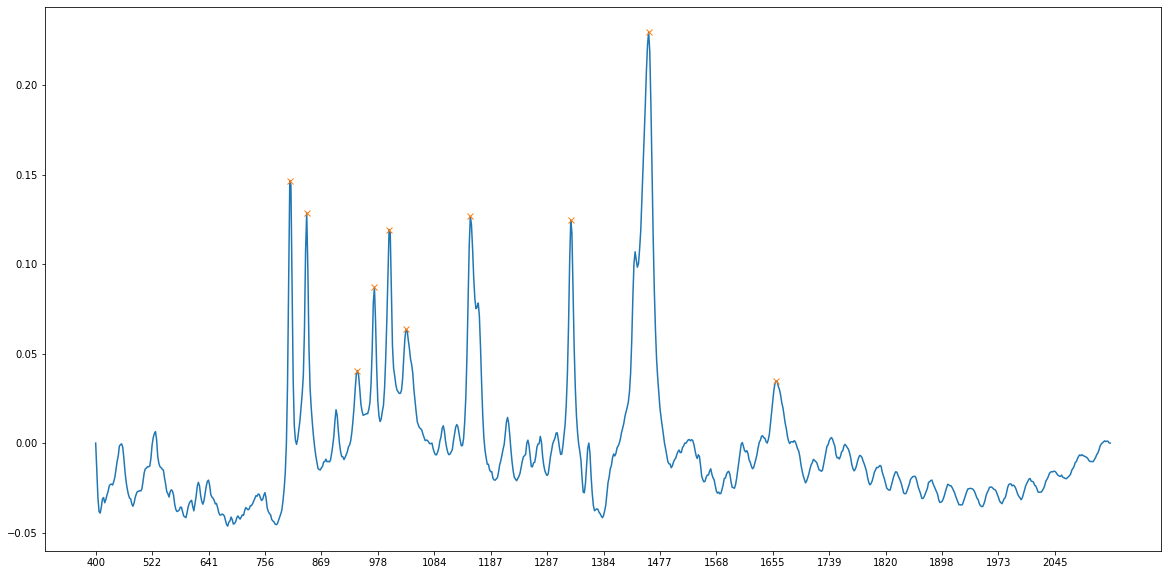

In [42]:
plt.figure(figsize=(20,10))
plt.plot(healthy.iloc[0, :])
plt.plot(peaks_h1, healthy.iloc[0, :][peaks_h1], "x")
plt.xticks(list(healthy.columns)[::50])
plt.show()

In [43]:
peaks_s1, _ = find_peaks(sars_cov_2.iloc[0, :], height=sars_cov_2.mean(axis=0)[sars_cov_2.mean(axis=0) > 0].quantile(0.5), prominence=0.01, distance=2)

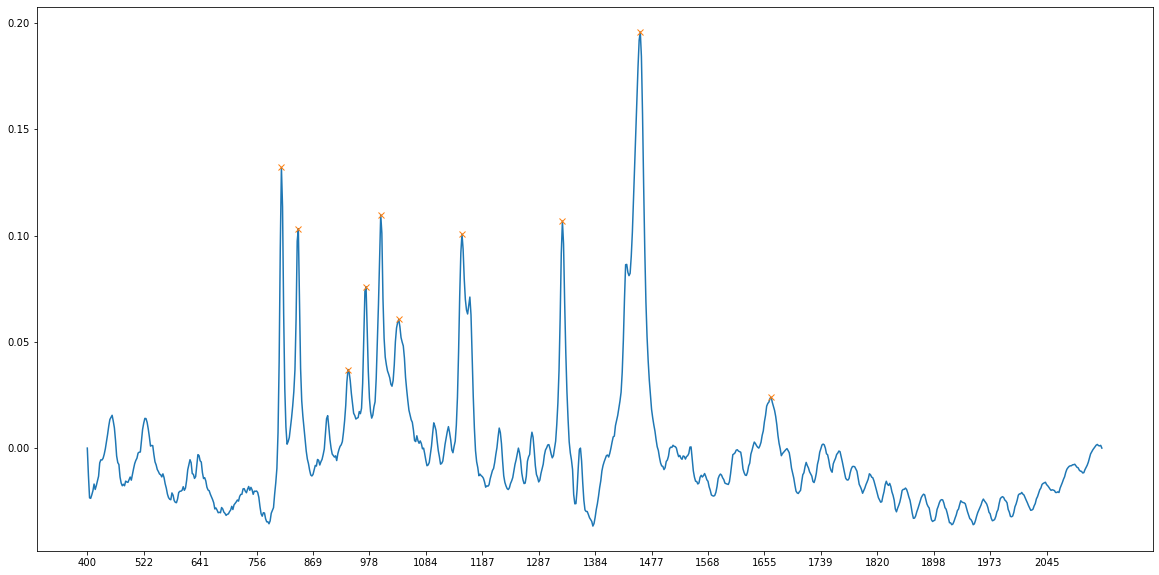

In [44]:
plt.figure(figsize=(20,10))
plt.plot(sars_cov_2.iloc[0, :])
plt.plot(peaks_s1, sars_cov_2.iloc[0, :][peaks_s1], "x")
plt.xticks(list(sars_cov_2.columns)[::50])
plt.show()

In [45]:
peaks_t1, _ = find_peaks(tube.iloc[0, :], height=0.01, prominence=0.05, distance=50)

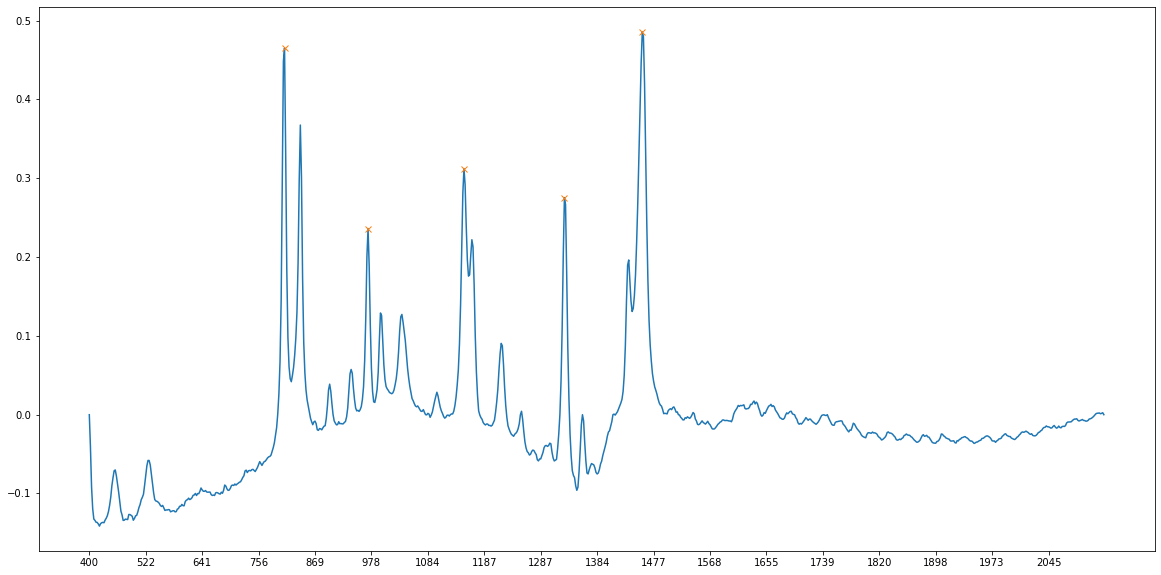

In [46]:
plt.figure(figsize=(20,10))
plt.plot(tube.iloc[0, :])
plt.plot(peaks_t1, tube.iloc[0, :][peaks_t1], "x")
plt.xticks(list(tube.columns)[::50])
plt.show()

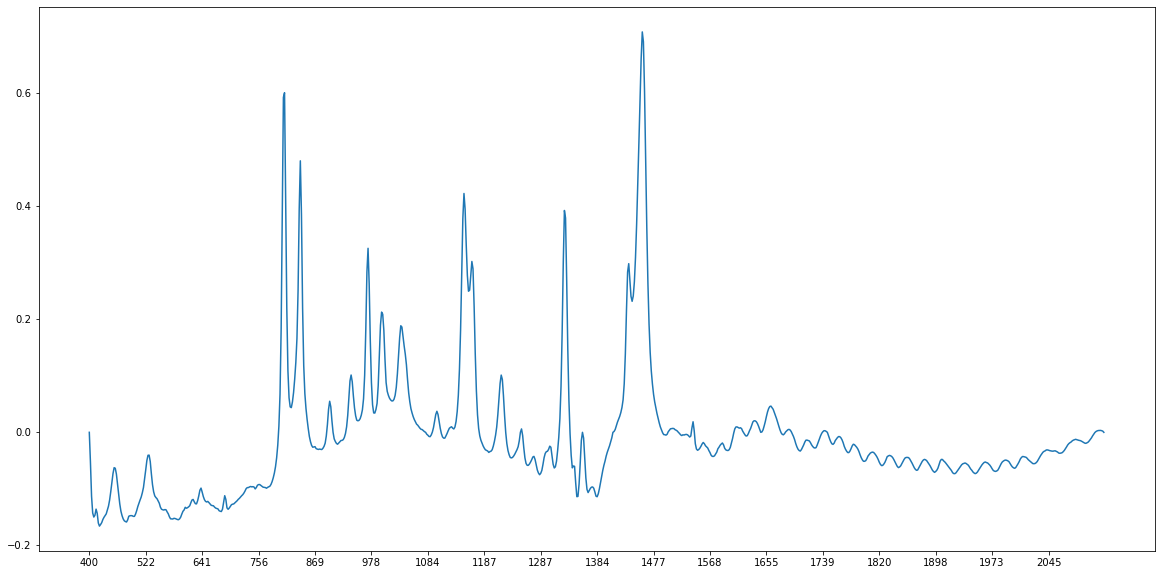

In [47]:
plt.figure(figsize=(20,10))
plt.plot(healthy.mean(axis=0) + tube.mean(axis=0))
plt.xticks(list(tube.columns)[::50])
plt.show()

Create dictionary for peaks between healthy and SARS_COV_2

Any non-zero value above the 50% percentile in height, prominence of 0.01 (low), and distance=2

In [48]:
healthy_signals = defaultdict(list)

In [49]:
for i in healthy.index:
    healthy_peaks, _ = find_peaks(healthy.loc[i, :], height=healthy.mean(axis=0)[healthy.mean(axis=0) > 0].quantile(0.5), prominence=0.01, distance=2)
    healthy_signals[str(i)].append(healthy_peaks)
    

In [50]:
sars_cov_2_signals = defaultdict(list)

In [51]:
for i in sars_cov_2.index:
    sars_peaks, _ = find_peaks(sars_cov_2.loc[i, :], height=sars_cov_2.mean(axis=0)[sars_cov_2.mean(axis=0) > 0].quantile(0.5), prominence=0.01, distance=2)
    sars_cov_2_signals[str(i)].append(sars_peaks)

95% confidence interval of Healthy Raman Spectra

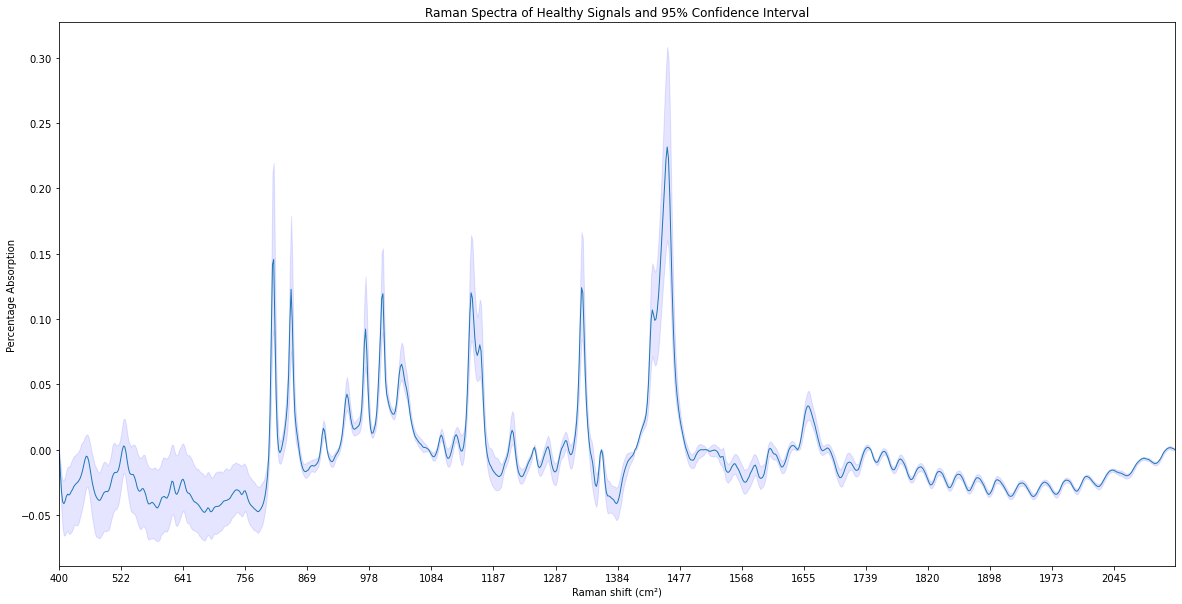

In [52]:
healthy_mean = healthy.mean(axis=0)
healthy_5 = healthy.quantile(0.05)
#healthy.mean(axis=0) + (2*healthy.std(axis=0))
healthy_95 = healthy.quantile(0.95)
#healthy.mean(axis=0) - (2*healthy.std(axis=0))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(healthy_mean, linewidth=1) #mean curve.
ax.fill_between(list(healthy.columns), healthy_5, healthy_95, color='b', alpha=.1) #std curves.
ax.set_title("Raman Spectra of Healthy Signals and 95% Confidence Interval")
ax.set_xlabel("Raman shift (cm\u00b2)")
ax.set_ylabel("Percentage Absorption")
ax.set_xlim("400", "2112")
ax.set_xticks(list(healthy.columns)[::50])
plt.show()




95% confidence interval of SARS-CoV-2 Raman Spectra

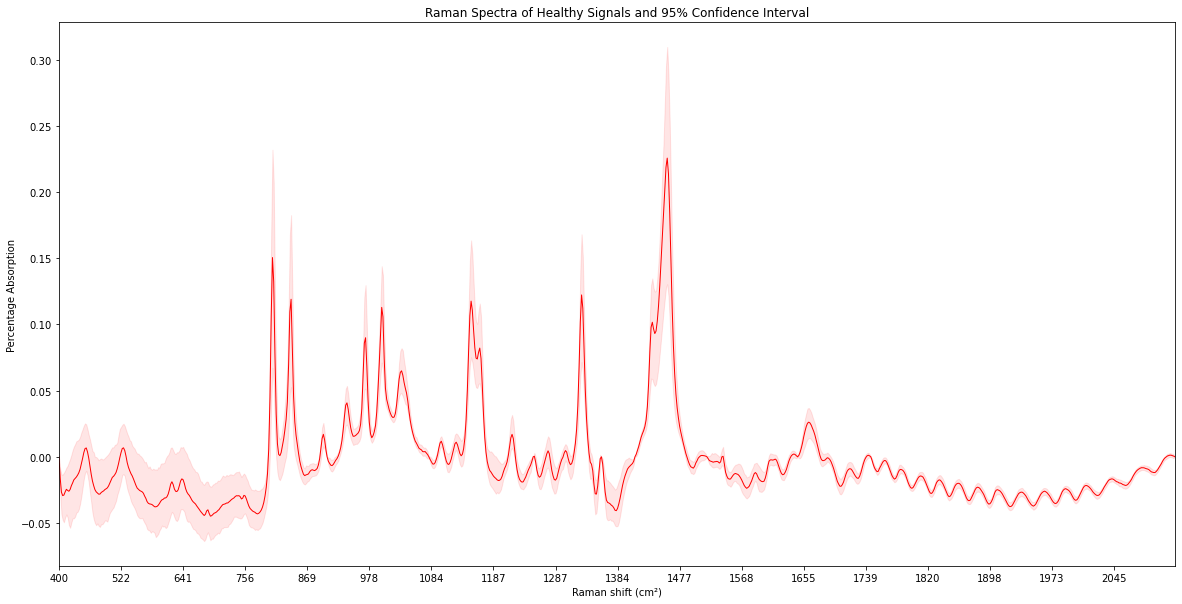

In [53]:
sars_mean = sars_cov_2.mean(axis=0)
sars_5 = sars_cov_2.quantile(0.05)
#healthy.mean(axis=0) + (2*healthy.std(axis=0))
sars_95 = sars_cov_2.quantile(0.95)
#healthy.mean(axis=0) - (2*healthy.std(axis=0))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(sars_mean, linewidth=1, color="r") #mean curve.
ax.fill_between(list(sars_cov_2.columns), sars_5, sars_95, color='r', alpha=.1) #std curves.
ax.set_title("Raman Spectra of Healthy Signals and 95% Confidence Interval")
ax.set_xlabel("Raman shift (cm\u00b2)")
ax.set_ylabel("Percentage Absorption")
ax.set_xlim("400", "2112")
ax.set_xticks(list(sars_cov_2.columns)[::50])
plt.show()



Superimposed mean spectra of healthy (n=150) and SARS-CoV-2 (n=159) spectra

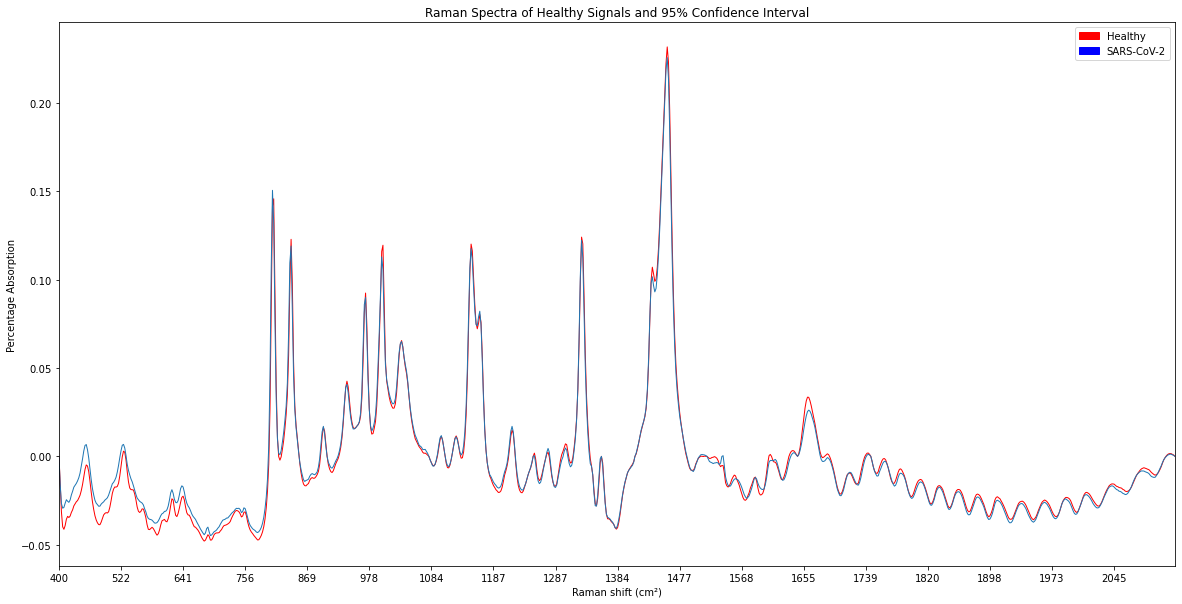

In [54]:
healthy_mean = healthy.mean(axis=0)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(healthy_mean, linewidth=1, color='r') #mean curve.

ax.set_title("Raman Spectra of Healthy Signals and 95% Confidence Interval")
ax.set_xlabel("Raman shift (cm\u00b2)")
ax.set_ylabel("Percentage Absorption")
ax.set_xlim("400", "2112")
ax.set_xticks(list(healthy.columns)[::50])

sars_mean = sars_cov_2.mean(axis=0)
ax.plot(sars_mean, linewidth=1) #mean curve.

red_patch = mpatches.Patch(color='red', label='Healthy')
blue_patch = mpatches.Patch(color='blue', label='SARS-CoV-2')

ax.legend(handles=[red_patch, blue_patch])

In [483]:
feat_importance_dict = {}
for x in range(len(spectra.columns[sorted_idx])):
    feat_importance_dict[spectra.columns[sorted_idx][x]] = feature_importance[sorted_idx][x]
feat_importance_dict

{'2080': 100.0,
 '2082': 98.49156385286814,
 '2085': 87.27123366359993,
 '1780': 73.53576021889617,
 '2086': 67.21882651852631,
 '801': 65.66539314660028,
 '799': 62.6654857399143,
 '1784': 61.225657205845216,
 '2046': 60.781519389168594,
 '2088': 59.89816532469138,
 '2089': 56.60447367340681,
 '2078': 54.16497881921032,
 '1761': 52.51142540970618,
 '1806': 50.355608955529455,
 '2055': 48.534399184381826,
 '2018': 47.344146978475955,
 '2084': 47.156133046507215,
 '2081': 46.16815040975904,
 '1996': 45.149151844182924,
 '1866': 40.604181119781614,
 '1762': 40.5510431564739,
 '891': 39.72803917894267,
 '1972': 39.70065218855831,
 '2048': 39.680441482192386,
 '2049': 38.84640702011064,
 '2077': 38.48950438355656,
 '989': 38.34442414756742,
 '1944': 36.779392508617605,
 '1924': 36.62523021802039,
 '1917': 36.29327363847867,
 '1804': 36.051074856037324,
 '1527': 34.69652087889874,
 '893': 34.159557478444,
 '1756': 33.81355690818412,
 '1995': 33.80840412954605,
 '2017': 32.885802887582486,
 

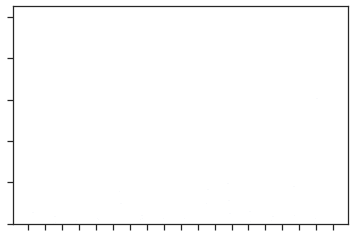

In [494]:
x_bar = spectra.columns[:-1]
y_bar = [feat_importance_dict[x] for x in spectra.columns[:-1]]
plt.bar(x_bar, y_bar, 0.1)
plt.xticks(list(spectra.columns)[::50])
plt.show()

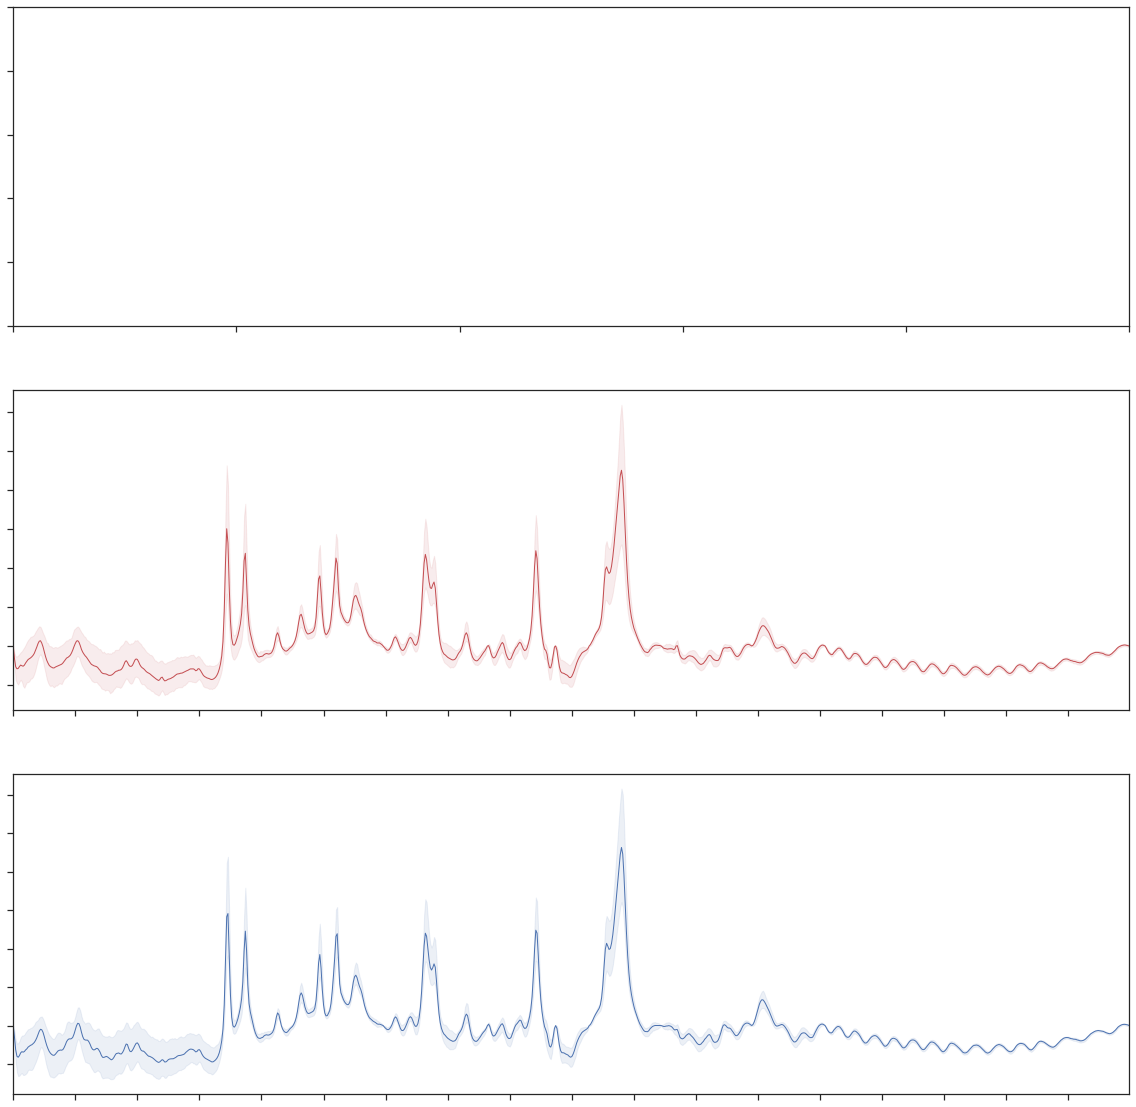

In [433]:
healthy_mean = healthy.mean(axis=0)
healthy_5 = healthy.quantile(0.05)
healthy_95 = healthy.quantile(0.95)

sars_mean = sars_cov_2.mean(axis=0)
sars_5 = sars_cov_2.quantile(0.05)
sars_95 = sars_cov_2.quantile(0.95)

fig, ax = plt.subplots(3, figsize=(20,20))

ax[0]

ax[1].plot(sars_mean, linewidth=1, color="r") #mean curve.
ax[1].fill_between(list(sars_cov_2.columns), sars_5, sars_95, color='r', alpha=.1) #std curves.
ax[1].set_title("Raman Spectra of Healthy Signals and 95% Confidence Interval")
ax[1].set_xlabel("Raman shift (cm\u00b2)")
ax[1].set_ylabel("Percentage Absorption")
ax[1].set_xlim("400", "2112")
ax[1].set_xticks(list(sars_cov_2.columns)[::50])

spectra.columns[sorted_idx[:100]]

ax[2].plot(healthy_mean, linewidth=1) #mean curve.
ax[2].fill_between(list(healthy.columns), healthy_5, healthy_95, color='b', alpha=.1) #std curves.
ax[2].set_title("Raman Spectra of Healthy Signals and 95% Confidence Interval")
ax[2].set_xlabel("Raman shift (cm\u00b2)")
ax[2].set_ylabel("Percentage Absorption")
ax[2].set_xlim("400", "2112")
ax[2].set_xticks(list(healthy.columns)[::50])

plt.show()

In [427]:
sorted_idx.shape

(200,)

In [55]:
(healthy_mean - sars_mean).nlargest(50) 

810     0.016614
842     0.013952
1001    0.013658
808     0.013493
1004    0.011426
1463    0.011334
1464    0.011153
1466    0.009464
1461    0.009410
1332    0.008990
1659    0.008471
1660    0.008141
1330    0.007924
1657    0.007865
1468    0.007746
844     0.007669
813     0.007646
1662    0.007245
1334    0.007007
1438    0.006692
1655    0.006614
1459    0.006053
1440    0.005929
1664    0.005922
974     0.005809
1470    0.005783
1152    0.005549
1436    0.005396
1442    0.005177
1154    0.005163
1653    0.005156
1336    0.005066
1665    0.004733
1444    0.004522
1472    0.004478
1338    0.004257
1451    0.004227
1450    0.004187
1340    0.004103
1453    0.004050
1474    0.003868
1446    0.003859
1448    0.003832
840     0.003810
976     0.003800
1607    0.003715
1667    0.003610
1528    0.003598
1457    0.003573
1527    0.003570
dtype: float64

Count number of peaks as a dictionary and merge counts within an uncertainty of +- 1 cm to the lower raman peak shift

In [56]:
healthy_signal_list = []
for i in range(len(healthy_signals)):
    healthy_signal_list.extend(list(list(sars_cov_2_signals.values())[i][0]))

healthy_signal_count = Counter(healthy_signal_list)
len(healthy_signal_count)

41

In [57]:
for a, b in itertools.combinations(healthy_signal_count.keys(), 2):
    if a + 1 == b:
        healthy_signal_count[a] = healthy_signal_count[a] + healthy_signal_count[b]
        del healthy_signal_count[b]
        
    if a - 1 == b:
        healthy_signal_count[b] = healthy_signal_count[a] + healthy_signal_count[b]
        del healthy_signal_count[a]
    else:
        pass
len(healthy_signal_count)

21

In [58]:
sars_signal_list = []
for i in range(len(sars_cov_2_signals)):
    sars_signal_list.extend(list(list(sars_cov_2_signals.values())[i][0]))

sars_signal_count = Counter(sars_signal_list)
len(sars_signal_count)

43

In [59]:
for a, b in itertools.combinations(sars_signal_count.keys(), 2):
    if a + 1 == b:
        sars_signal_count[a] = sars_signal_count[a] + sars_signal_count[b]
        del sars_signal_count[b]
        
    if a - 1 == b:
        sars_signal_count[b] = sars_signal_count[a] + sars_signal_count[b]
        del sars_signal_count[a]
    else:
        pass
len(sars_signal_count)

22

In [60]:
healthy_signal_count


Counter({172: 150,
         187: 150,
         231: 148,
         260: 150,
         332: 150,
         421: 150,
         490: 150,
         339: 57,
         365: 55,
         394: 5,
         477: 47,
         308: 2,
         535: 2,
         19: 22,
         51: 19,
         246: 150,
         212: 72,
         274: 150,
         602: 131,
         98: 3,
         606: 1})

In [61]:
sars_signal_count


Counter({172: 159,
         187: 159,
         231: 157,
         260: 159,
         332: 159,
         421: 159,
         490: 159,
         339: 59,
         394: 5,
         477: 49,
         308: 2,
         535: 2,
         19: 27,
         51: 23,
         246: 159,
         212: 77,
         274: 157,
         602: 140,
         98: 3,
         364: 60,
         276: 2,
         606: 1})

# Spearman's Rank Order Correlation

To get an understanding of collinearity between variables, we created feature_corr_matrix(df) that takes a data frame and returns the Spearman's rank-order correlation between all pairs of features as a matrix with feature names as index and column names.

Spearman's correlation is the same thing as converting two variables to rank values and then running a standard Pearson's correlation on those ranked variables. Spearman's is nonparametric and does not assume a linear relationship between the variables; it looks for monotonic relationships. 

In [62]:
def heatmap(df, method='pearson',annot=True):
        correlations = df.corr(method=method)
        ## Create color map ranging between two colors
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        fig, ax = plt.subplots(figsize=(10, 10))
        fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=annot, cbar_kws={"shrink": .75})
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
        fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
        plt.tight_layout()
        plt.show()

In [63]:
healthy_binned = pd.DataFrame(index=range(150), columns = range(450, 2150, 100))

In [64]:
for column in healthy_binned.columns:
    column_bin = list(range(column-50, column+50))
    wavelength_list = []
    for wavelength in healthy.columns:
        if int(wavelength) in column_bin:
            wavelength_list.append(wavelength)
        else:
            pass
    
    healthy_binned[column] = healthy.loc[:, wavelength_list[0]:wavelength_list[-1]].mean(axis=1)
    
    

In [65]:
healthy_binned.corr(method="spearman")

450       550       650       750       850       950       1050  \
450   1.000000  0.951696  0.922329  0.870618 -0.839979 -0.906865 -0.848886   
550   0.951696  1.000000  0.984981  0.941949 -0.684736 -0.813588 -0.821340   
650   0.922329  0.984981  1.000000  0.975810 -0.643149 -0.803269 -0.795635   
750   0.870618  0.941949  0.975810  1.000000 -0.559799 -0.774735 -0.747875   
850  -0.839979 -0.684736 -0.643149 -0.559799  1.000000  0.894829  0.738506   
950  -0.906865 -0.813588 -0.803269 -0.774735  0.894829  1.000000  0.848765   
1050 -0.848886 -0.821340 -0.795635 -0.747875  0.738506  0.848765  1.000000   
1150 -0.596153 -0.632560 -0.572209 -0.444288  0.463759  0.388741  0.629178   
1250  0.684281  0.537455  0.514890  0.526674 -0.735842 -0.751150 -0.542529   
1350  0.523495  0.488134  0.393121  0.268739 -0.504401 -0.337179 -0.457114   
1450 -0.898019 -0.799771 -0.803742 -0.793765  0.867205  0.946259  0.762788   
1550  0.375670  0.335469  0.404955  0.511520 -0.315778 -0.536975 -0.361138   
1650 -0.066671 -0.068431 -0.080894 -0.025574  0.158227  0.062778  0.117507   
1750  0.204221  0.139226  0.210756  0.337560 -0.187132 -0.410274 -0.161456   
1850  0.002861  0.050824  0.129480  0.273262  0.178922 -0.086335  0.016493   
1950 -0.347185 -0.257044 -0.210208 -0.093474  0.508871  0.330729  0.294795   
2050 -0.516234 -0.447776 -0.434169 -0.385992  0.519904  0.523314  0.402594   

          1150      1250      1350      1450      1550      1650      1750  \
450  -0.596153  0.684281  0.523495 -0.898019  0.375670 -0.066671  0.204221   
550  -0.632560  0.537455  0.488134 -0.799771  0.335469 -0.068431  0.139226   
650  -0.572209  0.514890  0.393121 -0.803742  0.404955 -0.080894  0.210756   
750  -0.444288  0.526674  0.268739 -0.793765  0.511520 -0.025574  0.337560   
850   0.463759 -0.735842 -0.504401  0.867205 -0.315778  0.158227 -0.187132   
950   0.388741 -0.751150 -0.337179  0.946259 -0.536975  0.062778 -0.410274   
1050  0.629178 -0.542529 -0.457114  0.762788 -0.361138  0.117507 -0.161456   
1150  1.000000 -0.097617 -0.750446  0.290088  0.118147  0.103701  0.437756   
1250 -0.097617  1.000000  0.330818 -0.770532  0.459500  0.032334  0.406971   
1350 -0.750446  0.330818  1.000000 -0.246569 -0.217412 -0.092529 -0.461814   
1450  0.290088 -0.770532 -0.246569  1.000000 -0.562373  0.081904 -0.492383   
1550  0.118147  0.459500 -0.217412 -0.562373  1.000000  0.188376  0.748693   
1650  0.103701  0.032334 -0.092529  0.081904  0.188376  1.000000  0.210930   
1750  0.437756  0.406971 -0.461814 -0.492383  0.748693  0.210930  1.000000   
1850  0.415533  0.069296 -0.535464 -0.182566  0.575985  0.256426  0.796339   
1950  0.445618 -0.261930 -0.508088  0.255949  0.166018  0.225882  0.372004   
2050  0.283140 -0.432394 -0.349792  0.498623 -0.194496  0.024625 -0.014463   

          1850      1950      2050  
450   0.002861 -0.347185 -0.516234  
550   0.050824 -0.257044 -0.447776  
650   0.129480 -0.210208 -0.434169  
750   0.273262 -0.093474 -0.385992  
850   0.178922  0.508871  0.519904  
950  -0.086335  0.330729  0.523314  
1050  0.016493  0.294795  0.402594  
1150  0.415533  0.445618  0.283140  
1250  0.069296 -0.261930 -0.432394  
1350 -0.535464 -0.508088 -0.349792  
1450 -0.182566  0.255949  0.498623  
1550  0.575985  0.166018 -0.194496  
1650  0.256426  0.225882  0.024625  
1750  0.796339  0.372004 -0.014463  
1850  1.000000  0.770123  0.337766  
1950  0.770123  1.000000  0.752793  
2050  0.337766  0.752793  1.000000

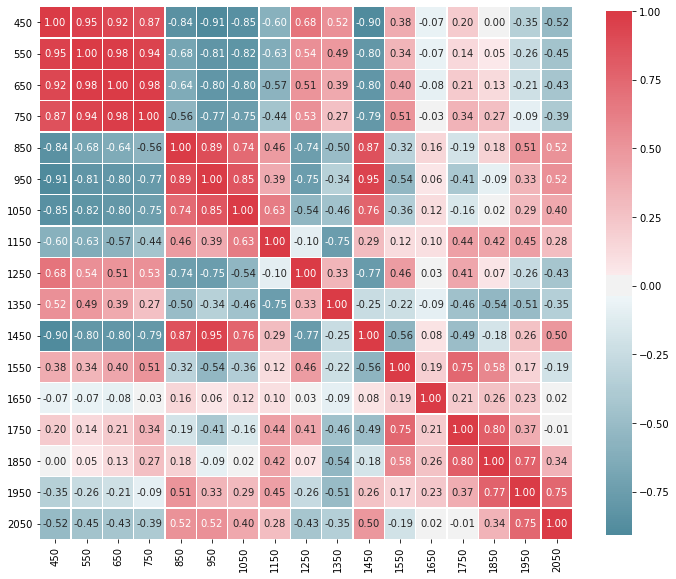

In [66]:
heatmap(healthy_binned, method='spearman',annot=True)

In [67]:
sars_cov_2_binned = pd.DataFrame(index=range(159), columns = range(450, 2150, 100))

In [68]:
for column in sars_cov_2_binned.columns:
    column_bin = list(range(column-50, column+50))
    wavelength_list = []
    for wavelength in sars_cov_2.columns:
        if int(wavelength) in column_bin:
            wavelength_list.append(wavelength)
        else:
            pass
    
    binned_column = sars_cov_2.loc[:, wavelength_list[0]:wavelength_list[-1]].mean(axis=1)
    binned_column.reset_index(inplace=True, drop=True)
    sars_cov_2_binned[column] = binned_column
    

In [69]:
sars_cov_2_binned.corr(method="spearman")

450       550       650       750       850       950       1050  \
450   1.000000  0.799767  0.705454  0.520707 -0.588357 -0.605690 -0.529729   
550   0.799767  1.000000  0.960607  0.859476 -0.226248 -0.346197 -0.364002   
650   0.705454  0.960607  1.000000  0.956362 -0.204705 -0.383404 -0.415297   
750   0.520707  0.859476  0.956362  1.000000 -0.057237 -0.291229 -0.359165   
850  -0.588357 -0.226248 -0.204705 -0.057237  1.000000  0.914405  0.759515   
950  -0.605690 -0.346197 -0.383404 -0.291229  0.914405  1.000000  0.901938   
1050 -0.529729 -0.364002 -0.415297 -0.359165  0.759515  0.901938  1.000000   
1150 -0.531938 -0.623525 -0.595755 -0.510252  0.399060  0.450914  0.570967   
1250  0.642507  0.270844  0.232625  0.083912 -0.851600 -0.811058 -0.633777   
1350  0.450439  0.300227  0.222041  0.062004 -0.624734 -0.505953 -0.441038   
1450 -0.631317 -0.359315 -0.419919 -0.345083  0.886318  0.944880  0.817832   
1550  0.276120  0.044250  0.133523  0.170632 -0.402953 -0.518778 -0.451311   
1650 -0.052962  0.105275  0.027576  0.000021  0.170922  0.211171  0.314452   
1750  0.214939  0.044364  0.117602  0.168566 -0.297325 -0.418172 -0.281535   
1850 -0.030792  0.262058  0.365518  0.503060  0.319056  0.105938  0.097119   
1950 -0.258180  0.090017  0.174116  0.315303  0.427221  0.260783  0.202624   
2050 -0.312270 -0.103583 -0.124000 -0.069829  0.288467  0.290703  0.236858   

          1150      1250      1350      1450      1550      1650      1750  \
450  -0.531938  0.642507  0.450439 -0.631317  0.276120 -0.052962  0.214939   
550  -0.623525  0.270844  0.300227 -0.359315  0.044250  0.105275  0.044364   
650  -0.595755  0.232625  0.222041 -0.419919  0.133523  0.027576  0.117602   
750  -0.510252  0.083912  0.062004 -0.345083  0.170632  0.000021  0.168566   
850   0.399060 -0.851600 -0.624734  0.886318 -0.402953  0.170922 -0.297325   
950   0.450914 -0.811058 -0.505953  0.944880 -0.518778  0.211171 -0.418172   
1050  0.570967 -0.633777 -0.441038  0.817832 -0.451311  0.314452 -0.281535   
1150  1.000000 -0.135580 -0.527860  0.340417  0.020182  0.080962  0.228368   
1250 -0.135580  1.000000  0.506795 -0.830198  0.460957 -0.069328  0.422459   
1350 -0.527860  0.506795  1.000000 -0.445337 -0.131511 -0.134446 -0.201875   
1450  0.340417 -0.830198 -0.445337  1.000000 -0.554627  0.257126 -0.480956   
1550  0.020182  0.460957 -0.131511 -0.554627  1.000000 -0.082422  0.750027   
1650  0.080962 -0.069328 -0.134446  0.257126 -0.082422  1.000000  0.141345   
1750  0.228368  0.422459 -0.201875 -0.480956  0.750027  0.141345  1.000000   
1850  0.090769 -0.199430 -0.401057  0.062184  0.327481  0.280929  0.581986   
1950  0.109715 -0.357798 -0.388184  0.274564  0.087339  0.336428  0.343955   
2050  0.080842 -0.309589 -0.189560  0.368241 -0.119435  0.366345  0.094638   

          1850      1950      2050  
450  -0.030792 -0.258180 -0.312270  
550   0.262058  0.090017 -0.103583  
650   0.365518  0.174116 -0.124000  
750   0.503060  0.315303 -0.069829  
850   0.319056  0.427221  0.288467  
950   0.105938  0.260783  0.290703  
1050  0.097119  0.202624  0.236858  
1150  0.090769  0.109715  0.080842  
1250 -0.199430 -0.357798 -0.309589  
1350 -0.401057 -0.388184 -0.189560  
1450  0.062184  0.274564  0.368241  
1550  0.327481  0.087339 -0.119435  
1650  0.280929  0.336428  0.366345  
1750  0.581986  0.343955  0.094638  
1850  1.000000  0.885894  0.462784  
1950  0.885894  1.000000  0.738778  
2050  0.462784  0.738778  1.000000

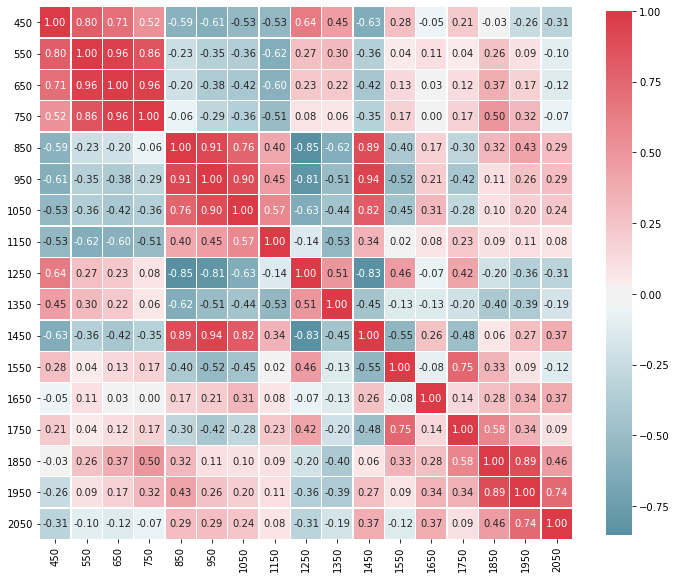

In [70]:
heatmap(sars_cov_2_binned, method='spearman',annot=True)

# Pearson Correlation

In [71]:
binned_data = pd.concat([healthy_binned, sars_cov_2_binned], ignore_index=True)

In [72]:
one_hot = [1 if outcome == 'Healthy' else 0 for outcome in spectra['diagnostic']]
binned_data['diagnostic'] = one_hot

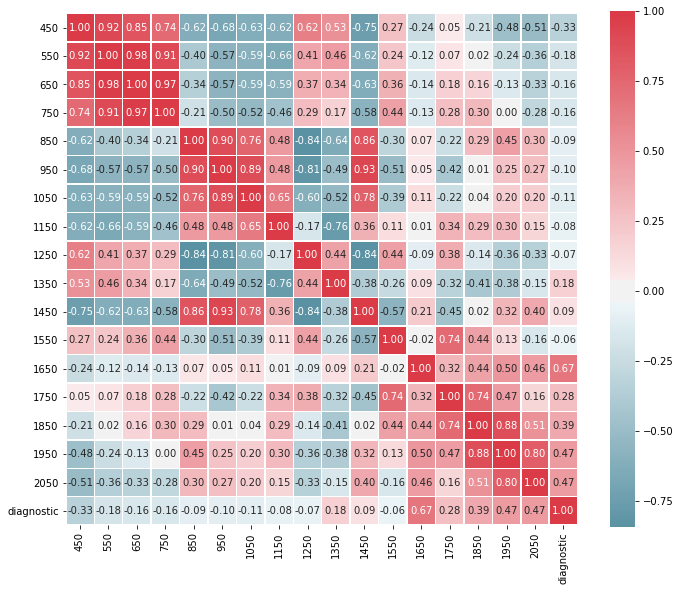

In [73]:
heatmap(binned_data)

# Pairplot Visualization of Binned Data

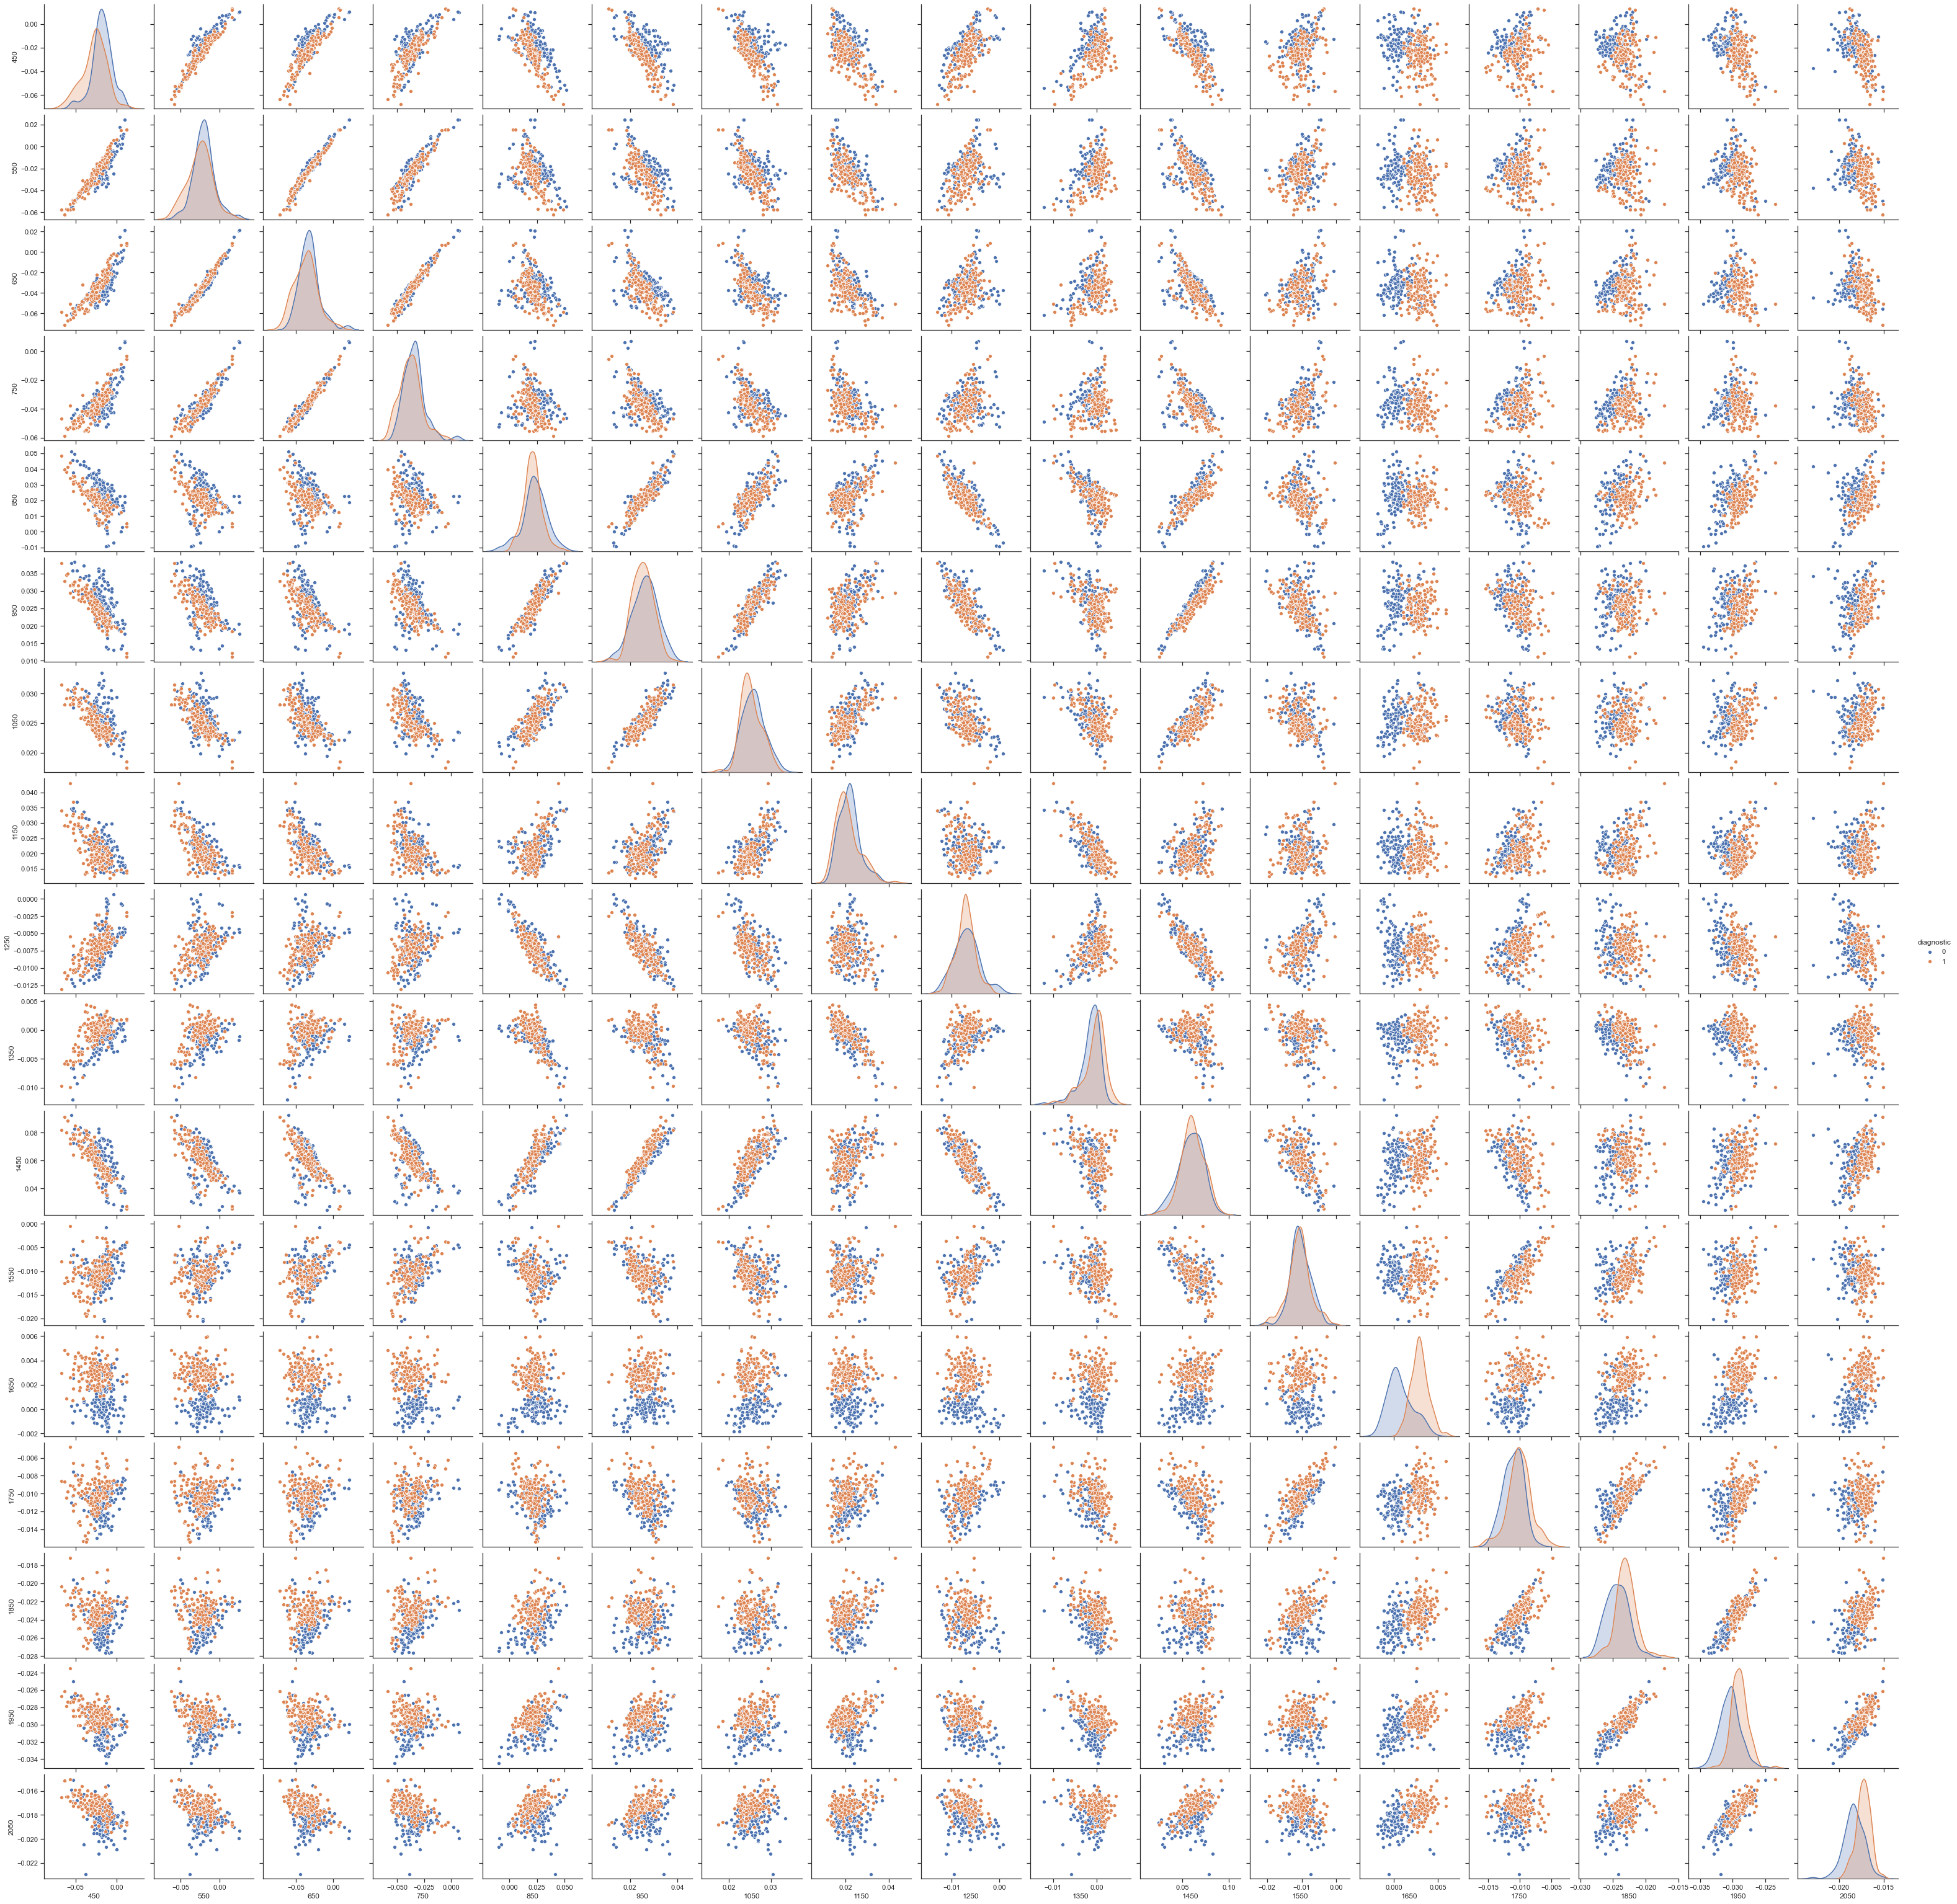

In [74]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(binned_data, hue='diagnostic')

# PCA Components Visualization

In [79]:
import plotly.express as px
from sklearn.decomposition import PCA

In [93]:
scaled = StandardScaler().fit_transform(spectra.iloc[:, :-1])
pca = PCA(n_components=5)
components = pca.fit_transform(scaled)


labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(5),
    color=spectra.iloc[:, -1]
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)
fig.update_traces(diagonal_visible=False)
fig.show()

In [83]:
from beakerx.object import beakerx
import cimcb_lite as cb

beakerx.pandas_display_table()
old = np.seterr(invalid='ignore')

BeakerxHTML(value='You need beakerx_tabledisplay to use this')

In [84]:
cb.plot.pca(spectra.iloc[:, :-1],
            pcx=1,                                                  # pc for x-axis
            pcy=2,                                                  # pc for y-axis
            group_label=spectra.iloc[:, -1])

Loading BokehJS ...

# Outlier Detection

In [94]:
def outliers_boxplot(df,nameOfFeature):
    
    trace0 = go.Box(
        y = df[nameOfFeature],
        name = "All Points",
        jitter = 0.3,
        pointpos = -1.8,
        boxpoints = 'all',
        marker = dict(
            color = 'rgb(7,40,89)'),
        line = dict(
            color = 'rgb(7,40,89)')
    )

    trace1 = go.Box(
        y = df[nameOfFeature],
        name = "Only Whiskers",
        boxpoints = False,
        marker = dict(
            color = 'rgb(9,56,125)'),
        line = dict(
            color = 'rgb(9,56,125)')
    )

    trace2 = go.Box(
        y = df[nameOfFeature],
        name = "Suspected Outliers",
        boxpoints = 'suspectedoutliers',
        marker = dict(
            color = 'rgb(8,81,156)',
            outliercolor = 'rgba(219, 64, 82, 0.6)',
            line = dict(
                outliercolor = 'rgba(219, 64, 82, 0.6)',
                outlierwidth = 2)),
        line = dict(
            color = 'rgb(8,81,156)')
    )

    trace3 = go.Box(
        y = df[nameOfFeature],
        name = "Whiskers and Outliers",
        boxpoints = 'outliers',
        marker = dict(
            color = 'rgb(107,174,214)'),
        line = dict(
            color = 'rgb(107,174,214)')
    )

    data = [trace0,trace1,trace2,trace3]

    layout = go.Layout(
        title = "{} Outliers".format(nameOfFeature)
    )

    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig, filename = "Outliers")

In [95]:
outliers_boxplot(binned_data,450)

# Outlier for PCA (2 components data)

In [96]:
scaled = StandardScaler().fit_transform(spectra.iloc[:, :-1])
pca_components = pd.DataFrame(columns=['PCA1', 'PCA2'], data=PCA(n_components=2).fit_transform(scaled))


In [97]:
outliers_boxplot(pca_components,'PCA1')

In [98]:
outliers_boxplot(pca_components,'PCA2')

# Outlier Detection on 2 component PCA data

In [99]:
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [100]:
def outlier_detection_paired(df,feature1,feature2,outliers_fraction=.1):
    
    new_df = df.copy()
    #rng = np.random.RandomState(42)

    # Example settings
    n_samples = new_df.shape[0]
#     outliers_fraction = 0.2 # ************************************** imp
    clusters_separation = [0]#, 1, 2]

    # define two outlier detection tools to be compared
    classifiers = {
        "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                         kernel="rbf", gamma=0.1),
        "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
        "Isolation Forest": IsolationForest(max_samples=n_samples,
                                            contamination=outliers_fraction,
                                            random_state=rng),
        "Local Outlier Factor": LocalOutlierFactor(
            n_neighbors=35,
            contamination=outliers_fraction)}

    
    xx, yy = np.meshgrid(np.linspace(new_df[feature1].min()-new_df[feature1].min()*10/100, 
                                     new_df[feature1].max()+new_df[feature1].max()*10/100, 50),
                         np.linspace(new_df[feature2].min()-new_df[feature2].min()*10/100,
                                     new_df[feature2].max()+new_df[feature2].max()*10/100, 50))


    n_inliers = int((1. - outliers_fraction) * n_samples)
    n_outliers = int(outliers_fraction * n_samples)
    ground_truth = np.ones(n_samples, dtype=int)
    ground_truth[-n_outliers:] = -1

    # Fit the problem with varying cluster separation
    for i, offset in enumerate(clusters_separation):
        # Data generation

        X = new_df[[feature1,feature2]].values.tolist()

        # Fit the model
        plt.figure(figsize=(20, 15))
        for i, (clf_name, clf) in enumerate(classifiers.items()):
            # fit the data and tag outliers
            if clf_name == "Local Outlier Factor":
                y_pred = clf.fit_predict(X)
                scores_pred = clf.negative_outlier_factor_
            else:
                clf.fit(X)
                scores_pred = clf.decision_function(X)
                y_pred = clf.predict(X)
            threshold = stats.scoreatpercentile(scores_pred,
                                                100 * outliers_fraction)
            n_errors = (y_pred != ground_truth).sum()
            
            unique, counts = np.unique(y_pred,return_counts=True)
            print(clf_name,dict(zip(unique, counts)))
            
            new_df[str(feature1)+'_'+str(feature2)+clf_name] = y_pred
#             print(clf_name,y_pred) 
            # plot the levels lines and the points
            if clf_name == "Local Outlier Factor":
                # decision_function is private for LOF
                Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape) 
            subplot = plt.subplot(2, 2, i + 1)
            
            subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                             cmap=plt.cm.Blues_r)
            a = subplot.contour(xx, yy, Z, levels=[threshold],
                                linewidths=2, colors='red')
            subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                             colors='orange')
            b = plt.scatter(new_df[feature1], new_df[feature2], c='white',
                     s=20, edgecolor='k')

            #subplot.axis('tight')

            subplot.set_xlabel("%s" % (feature1))
            subplot.set_xlim([-43, 50])
            subplot.set_ylim([-30, 69])
 
            plt.ylabel(str(feature2))#, fontsize=18)
            plt.title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))

        plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.25, 0.3)
#         plt.suptitle("Outlier detection")

    plt.show()

One-Class SVM {-1: 116, 1: 193}
Robust covariance {-1: 31, 1: 278}
Isolation Forest {-1: 31, 1: 278}
Local Outlier Factor {-1: 31, 1: 278}


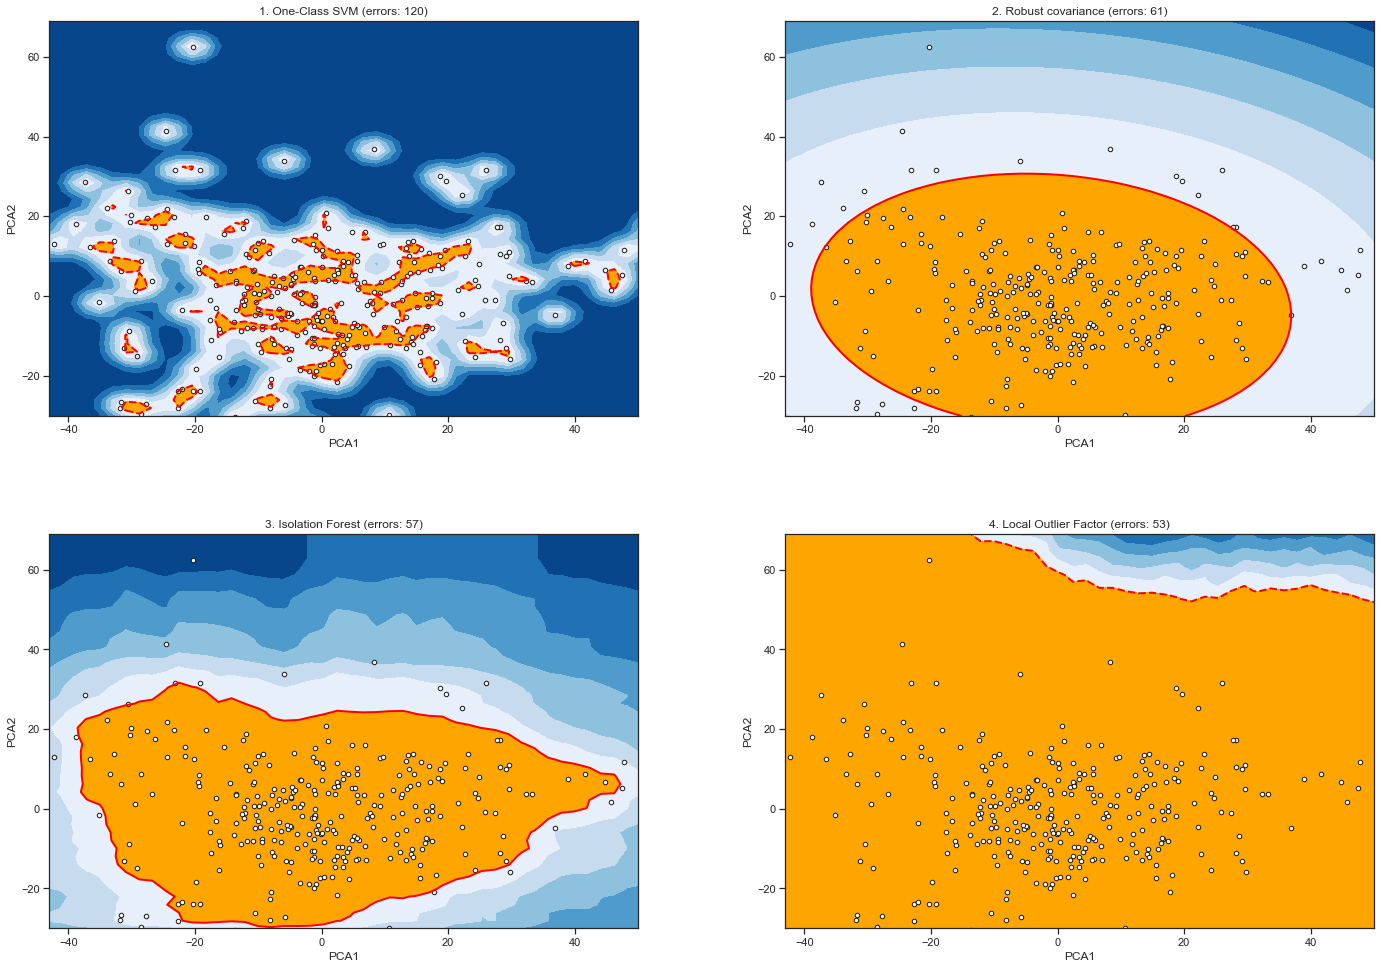

In [101]:
outlier_detection_paired(pca_components,'PCA1','PCA2',outliers_fraction=0.10)

# Baseline Algorithm Evaluation

In [102]:
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as score

In [103]:
X = spectra.iloc[:, :-1]
Y = spectra.iloc[:, -1]
X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=spectra['diagnostic'])

In [104]:
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    return basedModels

In [105]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [106]:
class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [107]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.778623 (0.063637)
LDA: 0.939312 (0.052237)
KNN: 0.882790 (0.064844)
CART: 0.869746 (0.072971)
NB: 0.887138 (0.062304)
SVM: 0.856522 (0.061641)
AB: 0.904710 (0.066849)
GBM: 0.926268 (0.043824)
RF: 0.939130 (0.052174)
ET: 0.930616 (0.052267)


In [108]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [109]:
basedLineScore = ScoreDataFrame(names,results)
basedLineScore

Model   Score
0    LR  0.7786
1   LDA  0.9393
2   KNN  0.8828
3  CART  0.8697
4    NB  0.8871
5   SVM  0.8565
6    AB  0.9047
7   GBM  0.9263
8    RF  0.9391
9    ET  0.9306

# Feature Engineering

## A. Data PreProcessing

In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [111]:
def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))


    return pipelines

### Standard Scaling

In [112]:
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)
scaledScoreStandard = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard], axis=1)
compareModels

standardLR: 0.952355 (0.045413)
standardLDA: 0.939312 (0.052237)
standardKNN: 0.917572 (0.053208)
standardCART: 0.861051 (0.064173)
standardNB: 0.887138 (0.062304)
standardSVM: 0.943659 (0.047879)
standardAB: 0.904710 (0.066849)
standardGBM: 0.921920 (0.038073)
standardRF: 0.930616 (0.044449)
standardET: 0.939312 (0.044414)


Model   Score         Model   Score
0    LR  0.7786    standardLR  0.9524
1   LDA  0.9393   standardLDA  0.9393
2   KNN  0.8828   standardKNN  0.9176
3  CART  0.8697  standardCART  0.8611
4    NB  0.8871    standardNB  0.8871
5   SVM  0.8565   standardSVM  0.9437
6    AB  0.9047    standardAB  0.9047
7   GBM  0.9263   standardGBM  0.9219
8    RF  0.9391    standardRF  0.9306
9    ET  0.9306    standardET  0.9393

### Min Max Scaling

In [113]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

scaledScoreMinMax = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax], axis=1)
compareModels

minmaxLR: 0.952355 (0.041040)
minmaxLDA: 0.939312 (0.052237)
minmaxKNN: 0.921920 (0.046965)
minmaxCART: 0.865580 (0.049743)
minmaxNB: 0.887138 (0.062304)
minmaxSVM: 0.934964 (0.044644)
minmaxAB: 0.904710 (0.066849)
minmaxGBM: 0.930616 (0.048516)
minmaxRF: 0.930616 (0.048516)
minmaxET: 0.930616 (0.052267)


Model   Score         Model   Score       Model   Score
0    LR  0.7786    standardLR  0.9524    minmaxLR  0.9524
1   LDA  0.9393   standardLDA  0.9393   minmaxLDA  0.9393
2   KNN  0.8828   standardKNN  0.9176   minmaxKNN  0.9219
3  CART  0.8697  standardCART  0.8611  minmaxCART  0.8656
4    NB  0.8871    standardNB  0.8871    minmaxNB  0.8871
5   SVM  0.8565   standardSVM  0.9437   minmaxSVM  0.9350
6    AB  0.9047    standardAB  0.9047    minmaxAB  0.9047
7   GBM  0.9263   standardGBM  0.9219   minmaxGBM  0.9306
8    RF  0.9391    standardRF  0.9306    minmaxRF  0.9306
9    ET  0.9306    standardET  0.9393    minmaxET  0.9306

## B. Remove Outliers

In [114]:
spectra_ro = spectra.copy()
spectra_names = spectra.columns

In [115]:
def outlier_column_removal(df_out,nameOfFeature,drop=False):

    valueOfFeature = df_out[nameOfFeature]
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(valueOfFeature, 25.)

    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(valueOfFeature, 75.)

    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1)*1.5
    # print "Outlier step:", step
    outliers = valueOfFeature[~((valueOfFeature >= Q1 - step) & (valueOfFeature <= Q3 + step))].index.tolist()
    feature_outliers = valueOfFeature[~((valueOfFeature >= Q1 - step) & (valueOfFeature <= Q3 + step))].values
    # df[~((df[nameOfFeature] >= Q1 - step) & (df[nameOfFeature] <= Q3 + step))]


    # Remove the outliers, if any were specified
    print ("Number of outliers (inc duplicates): {} and outliers: {}".format(len(outliers), feature_outliers))
    if drop:
        good_data = df_out.drop(df_out.index[outliers]).reset_index(drop = True)
        print ("New dataset with removed outliers has {} samples with {} features each.".format(*good_data.shape))
        return good_data
    else: 
        print ("Nothing happens, df.shape = ",df_out.shape)
        return df_out

Before removing outliers for column 402

In [116]:
feature_number = 1
outliers_boxplot(spectra,spectra_names[feature_number])

In [117]:
def outlier_removal(df_out):

    Q1 = df_out.quantile(0.25)
    Q3 = df_out.quantile(0.75)
    IQR = Q3 - Q1
    idx = ~((df_out < (Q1 - 3 * IQR)) | (df_out > (Q3 + 3 * IQR))).any(axis=1)
    
    return df_out.loc[idx]


In [118]:
test = outlier_column_removal(spectra_ro,spectra_names[feature_number],True)
outliers_boxplot(test,spectra_names[feature_number])

Number of outliers (inc duplicates): 8 and outliers: [-0.03012453 -0.00221934 -0.0028435  -0.02914014 -0.02842812 -0.03039303
 -0.02759559 -0.03412551]
New dataset with removed outliers has 301 samples with 901 features each.


In [119]:
X_clean = outlier_removal(spectra)
X_clean = spectra.loc[spectra.index & X_clean.index]

In [120]:
print('df shape: {}, new df shape: {}, we lost {} rows, {}% of our data'.format(X.shape[0],X_clean.shape[0],
                                                              X.shape[0]-X_clean.shape[0],
                                                        (X.shape[0]-X_clean.shape[0])/X.shape[0]*100))

df shape: 309, new df shape: 250, we lost 59 rows, 19.093851132686083% of our data


Comparing the accuracy of models after cleaning

In [121]:
X_clean_name = X_clean.columns
X_c =  X_clean[X_clean_name[:-1]]
Y_c = X_clean[X_clean_name[-1]]
X_train_c, X_test_c, y_train_c, y_test_c =train_test_split(X_c,Y_c,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=X_clean['diagnostic'])

In [122]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train_c, y_train_c,models)
PlotBoxR().PlotResult(names,results)

scaledScoreMinMax_c = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax,
                          scaledScoreMinMax_c], axis=1)
compareModels

minmaxLR: 0.968129 (0.026037)
minmaxLDA: 0.968129 (0.035099)
minmaxKNN: 0.941228 (0.037592)
minmaxCART: 0.864912 (0.092416)
minmaxNB: 0.924854 (0.049571)
minmaxSVM: 0.957018 (0.032875)
minmaxAB: 0.952339 (0.036894)


KeyboardInterrupt: 

## C. Feature Importance

In [447]:
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=SEED)
clf.fit(X_train_c, y_train_c)


ExtraTreesClassifier(n_estimators=250, random_state=10)

In [450]:
sorted_idx

array([875, 877, 879, 675, 880, 170, 169, 677, 851, 881, 882, 874, 663,
       691, 857, 831, 878, 876, 816, 729, 664, 210, 799, 852, 853, 873,
       255, 780, 767, 762, 690, 527, 211, 660, 815, 830, 676, 571, 833,
       766, 856, 855, 764, 436, 601, 872, 674, 271, 854, 171, 818, 661,
       763, 665, 599, 859, 678, 797, 834, 649, 829, 756, 757, 850, 647,
       781, 782, 617, 572, 616, 404, 253, 761, 602, 694, 692, 588, 752,
       673, 728, 743, 732, 783, 600, 832, 603, 528, 168, 858, 167, 384,
       529, 182, 693, 254, 835, 695, 180, 269, 733, 196, 798, 287, 724,
       409, 573, 883, 778, 179,  22, 405, 590, 648, 662, 604, 212, 726,
       812, 195, 754, 270,   3, 256, 760, 777, 257, 801, 410,  21, 758,
       383, 741, 765, 550, 292, 618, 800, 730, 178, 221,  50, 806, 751,
         5, 591, 427, 166, 759, 864, 738, 735,   4, 385, 530, 779, 197,
       403, 774, 185, 607, 419, 888, 288, 406, 262, 535, 866, 586, 589,
       272, 526, 371, 534, 689, 731, 536, 802, 294, 886, 598, 64

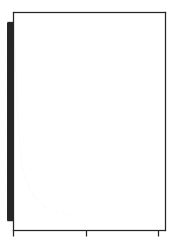

In [449]:
# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]
#[:200]

pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_c.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [130]:
df_feature_imp=X_clean[X_clean.columns[sorted_idx]]
df_feature_imp['diagnostic'] = X_clean['diagnostic']

In [131]:
df_feature_imp_name = df_feature_imp.columns

In [132]:
X =  df_feature_imp[df_feature_imp_name[0:df_feature_imp.shape[1]-1]]
Y = df_feature_imp[df_feature_imp_name[df_feature_imp.shape[1]-1]]
X_train_im, X_test_im, y_train_im, y_test_im =train_test_split(X,Y,
                                                   test_size=0.1,
                                                   random_state=0,
                                                   stratify=df_feature_imp['diagnostic'])

In [133]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train_im, y_train_im,models)
PlotBoxR().PlotResult(names,results)

scaledScoreMinMax_im = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax,
                          scaledScoreMinMax_c,
                          scaledScoreMinMax_im], axis=1)
compareModels

minmaxLR: 0.964229 (0.039500)
minmaxLDA: 0.586957 (0.103116)
minmaxKNN: 0.973123 (0.041494)
minmaxCART: 0.892885 (0.064421)
minmaxNB: 0.941700 (0.054182)
minmaxSVM: 0.968577 (0.045570)
minmaxAB: 0.933597 (0.062970)
minmaxGBM: 0.910672 (0.078753)
minmaxRF: 0.946245 (0.056907)
minmaxET: 0.950791 (0.037865)


NameError: name 'scaledScoreMinMax_c' is not defined

## D. Feature Selection

### Recursive Feature Elimination 

The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.

It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [84]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [230]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

Optimal number of features : 709
Num Features: 709
Selected Features: [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False  True  True
  True  True  True  True False  True  True False  True  True  True False
  True  True  True False  True  True False  True  True  True  True False
  True  True False  True  True False  True  True  True  True False  True
  True False  True  True  True  True  True False  True False  True  True
  True  True  True  True False False False False False  True  True  True
 False False False  True  True  True  True  True  True  True False False
 False  True  True  True  True  True  True  True  True  True False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True

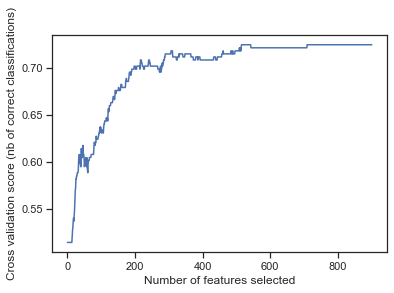

In [231]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(spectra.iloc[:, :-1], spectra.iloc[:, -1])

print("Optimal number of features : %d" % rfecv.n_features_)

print("Num Features: %s" % (rfecv.n_features_))
print("Selected Features: %s" % (rfecv.support_))
print("Feature Ranking: %s" % (rfecv.ranking_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()


In [85]:
model =RandomForestClassifier(n_estimators=100)
rfe = RFE(model, 10)
fit = rfe.fit(spectra.iloc[:, :-1], spectra.iloc[:, -1])
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 10
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False Fa

In [86]:
spectra.columns[fit.ranking_[:10]]

Index(['2101', '2095', '2093', '2085', '2080', '2027', '2022', '2021', '2018',
       '2017'],
      dtype='object')

### Feature importance with Forests of Trees

Feature ranking:
1. feature 879 (0.013780)
2. feature 875 (0.013496)
3. feature 817 (0.013131)
4. feature 878 (0.011875)
5. feature 661 (0.011079)
6. feature 675 (0.010689)
7. feature 663 (0.010320)
8. feature 881 (0.009736)
9. feature 873 (0.009131)
10. feature 662 (0.008465)
11. feature 384 (0.008343)
12. feature 877 (0.008031)
13. feature 169 (0.007980)
14. feature 818 (0.007885)
15. feature 210 (0.007866)
16. feature 170 (0.007795)
17. feature 834 (0.007597)
18. feature 691 (0.007521)
19. feature 831 (0.007503)
20. feature 874 (0.007493)
21. feature 832 (0.007061)
22. feature 880 (0.006565)
23. feature 255 (0.005949)
24. feature 211 (0.005828)
25. feature 674 (0.005441)
26. feature 816 (0.005387)
27. feature 601 (0.005262)
28. feature 815 (0.005244)
29. feature 876 (0.005243)
30. feature 814 (0.005131)
31. feature 833 (0.005094)
32. feature 602 (0.005040)
33. feature 765 (0.004974)
34. feature 764 (0.004917)
35. feature 676 (0.004790)
36. feature 859 (0.004782)
37. feature 763 (0.0

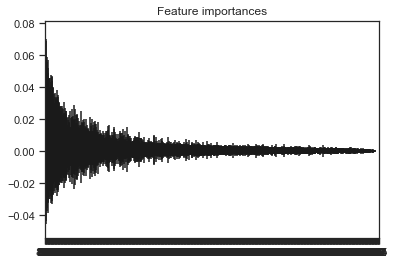

In [271]:
# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(spectra.iloc[:, :-1], spectra.iloc[:, -1])
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Dimensionality Reduction and Binary Class Visualization in 3D plots

In [163]:
from mpl_toolkits.mplot3d import Axes3D

### Principal Component Analysis

In [165]:

from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler

from beakerx.object import beakerx
import cimcb_lite as cb

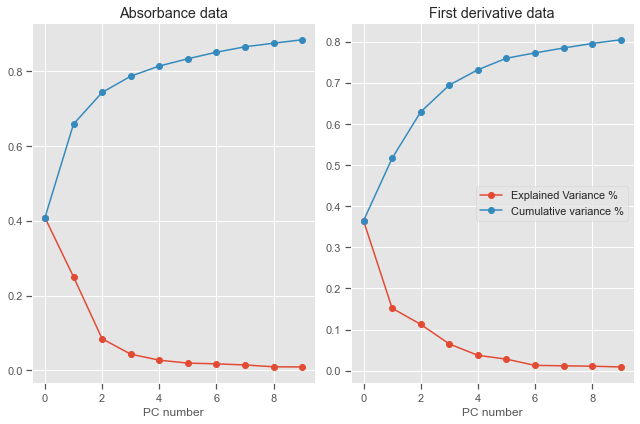

In [91]:
feat = healthy
# Calculate first derivative applying a Savitzky-Golay filter
dfeat = savgol_filter(feat, 25, polyorder = 5, deriv=1)

# Initialise
skpca1 = PCA(n_components=10)
skpca2 = PCA(n_components=10)
# Scale the features to have zero mean and standard devisation of 1
# This is important when correlating data with very different variances
nfeat1 = StandardScaler().fit_transform(feat)
nfeat2 = StandardScaler().fit_transform(dfeat)
# Fit the spectral data and extract the explained variance ratio
X1 = skpca1.fit(nfeat1)
expl_var_1 = X1.explained_variance_ratio_
# Fit the first data and extract the explained variance ratio
X2 = skpca2.fit(nfeat2)
expl_var_2 = X2.explained_variance_ratio_
# Plot data
with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)
    ax1.plot(expl_var_1,'-o', label="Explained Variance %")
    ax1.plot(np.cumsum(expl_var_1),'-o', label = 'Cumulative variance %')
    ax1.set_xlabel("PC number")
    ax1.set_title('Absorbance data')
    ax2.plot(expl_var_2,'-o', label="Explained Variance %")
    ax2.plot(np.cumsum(expl_var_2),'-o', label = 'Cumulative variance %')
    ax2.set_xlabel("PC number")
    ax2.set_title('First derivative data')
    plt.legend()
    plt.show()

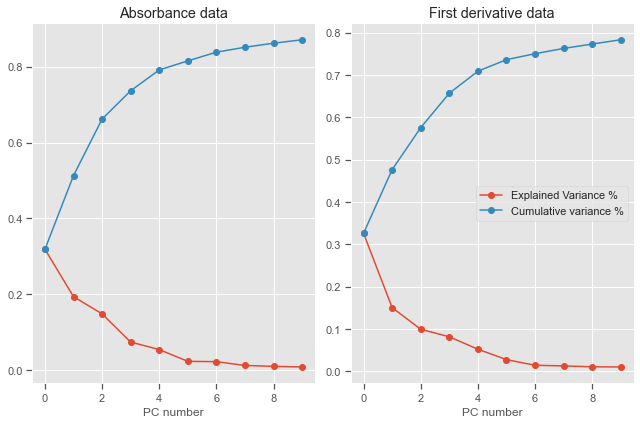

In [92]:
feat = sars_cov_2
# Calculate first derivative applying a Savitzky-Golay filter
dfeat = savgol_filter(feat, 25, polyorder = 5, deriv=1)

# Initialise
skpca1 = PCA(n_components=10)
skpca2 = PCA(n_components=10)
# Scale the features to have zero mean and standard devisation of 1
# This is important when correlating data with very different variances
nfeat1 = StandardScaler().fit_transform(feat)
nfeat2 = StandardScaler().fit_transform(dfeat)
# Fit the spectral data and extract the explained variance ratio
X1 = skpca1.fit(nfeat1)
expl_var_1 = X1.explained_variance_ratio_
# Fit the first data and extract the explained variance ratio
X2 = skpca2.fit(nfeat2)
expl_var_2 = X2.explained_variance_ratio_
# Plot data
with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)
    ax1.plot(expl_var_1,'-o', label="Explained Variance %")
    ax1.plot(np.cumsum(expl_var_1),'-o', label = 'Cumulative variance %')
    ax1.set_xlabel("PC number")
    ax1.set_title('Absorbance data')
    ax2.plot(expl_var_2,'-o', label="Explained Variance %")
    ax2.plot(np.cumsum(expl_var_2),'-o', label = 'Cumulative variance %')
    ax2.set_xlabel("PC number")
    ax2.set_title('First derivative data')
    plt.legend()
    plt.show()

In [93]:
pca_s = PCA(n_components=3)
pc_sars = pca_s.fit_transform(sars_cov_2)

In [94]:
sars_pca_df = pd.DataFrame(data = pc_sars
             , columns = ['PC1', 'PC2', 'PC3' ])


In [95]:
print('Explained variation per principal component: {}'.format(pca_s.explained_variance_ratio_))

Explained variation per principal component: [0.68979657 0.19713371 0.05303383]


In [96]:
print('Explained variation per principal component: {}'.format(pca_s.explained_variance_ratio_.sum()))

Explained variation per principal component: 0.9399641114763637


In [97]:
pca_h = PCA(n_components=3)
pc_healthy = pca_h.fit_transform(healthy)

In [98]:
healthy_pca_df = pd.DataFrame(data = pc_healthy
             , columns = ['PC1', 'PC2', 'PC3' ])


In [99]:
print('Explained variation per principal component: {}'.format(pca_h.explained_variance_ratio_))

Explained variation per principal component: [0.82383095 0.08245105 0.05966081]


In [100]:
print('Explained variation per principal component: {}'.format(pca_h.explained_variance_ratio_.sum()))

Explained variation per principal component: 0.965942813198753


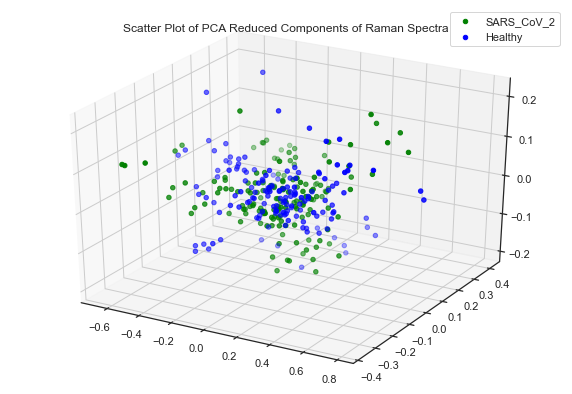

In [101]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter(sars_pca_df['PC1'], sars_pca_df['PC2'], sars_pca_df['PC3'], label='SARS_CoV_2', color = "green")
ax.scatter(healthy_pca_df['PC1'], healthy_pca_df['PC2'], healthy_pca_df['PC3'], label='Healthy', color = "blue")

plt.title("Scatter Plot of PCA Reduced Components of Raman Spectra")
ax.legend()
# show plot
plt.show()

In [183]:
spectra_data = pd.read_csv("/Users/davidchen/Documents/GitHub/Erevna/covid_and_healthy_spectra.csv").iloc[:, :-1]
spectra_data["index"] = spectra_data.index

In [184]:
spectra_data.fillna(0, inplace=True)
spectra_data[spectra_data <= 0] = 0.01

### t-distributed Stochastic Neighbor Embedding

In [102]:
from sklearn.manifold import TSNE

In [103]:
tsne_s = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=1000)
tsne_sars = tsne_s.fit_transform(sars_cov_2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 159 samples in 0.001s...
[t-SNE] Computed neighbors for 159 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 159 / 159
[t-SNE] Mean sigma: 0.103308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.779587
[t-SNE] KL divergence after 1000 iterations: 1.407079


In [104]:
sars_tsne_df = pd.DataFrame(data = tsne_sars
             , columns = ['T1', 'T2', 'T3' ])

In [105]:
tsne_h = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=1000)
tsne_healthy = tsne_s.fit_transform(healthy)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.089877
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.530563
[t-SNE] KL divergence after 1000 iterations: 1.606772


In [106]:
healthy_tsne_df = pd.DataFrame(data = tsne_healthy
             , columns = ['T1', 'T2', 'T3' ])

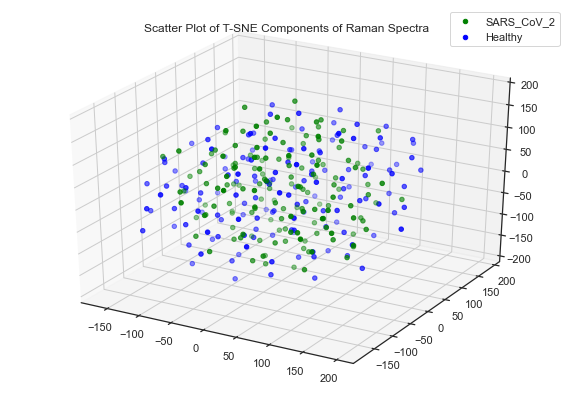

In [107]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter(sars_tsne_df['T1'], sars_tsne_df['T2'], sars_tsne_df['T3'], label='SARS_CoV_2', color = "green")
ax.scatter(healthy_tsne_df['T1'], healthy_tsne_df['T2'], healthy_tsne_df['T3'], label='Healthy', color = "blue")

plt.title("Scatter Plot of T-SNE Components of Raman Spectra")
ax.legend()
# show plot
plt.show()

### Singular Value Decomposition (sparse datasets usually)

In [108]:
from sklearn.decomposition import TruncatedSVD

In [109]:
svd_s = TruncatedSVD(n_components=3)
svd_sars = svd_s.fit_transform(sars_cov_2)

In [110]:
sars_svd_df = pd.DataFrame(data = svd_sars
             , columns = ['SV1', 'SV2', 'SV3' ])


In [111]:
print('Explained variation per principal component: {}'.format(svd_s.explained_variance_ratio_))

Explained variation per principal component: [0.5394972  0.20477879 0.16309378]


In [112]:
print('Explained variation per principal component: {}'.format(svd_s.explained_variance_ratio_.sum()))

Explained variation per principal component: 0.9073697706247877


In [113]:
svd_h = TruncatedSVD(n_components=3)
svd_healthy = svd_h.fit_transform(healthy)

In [114]:
healthy_svd_df = pd.DataFrame(data = svd_healthy
             , columns = ['SV1', 'SV2', 'SV3' ])


In [115]:
print('Explained variation per principal component: {}'.format(svd_h.explained_variance_ratio_))

Explained variation per principal component: [0.62468804 0.23471811 0.06053137]


In [116]:
print('Explained variation per principal component: {}'.format(svd_h.explained_variance_ratio_.sum()))

Explained variation per principal component: 0.9199375201977152


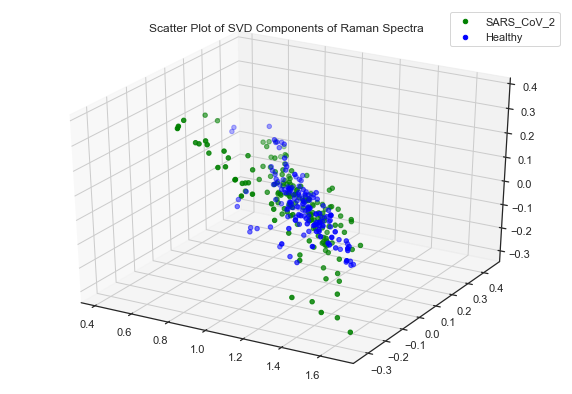

In [117]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter(sars_svd_df['SV1'], sars_svd_df['SV2'], sars_svd_df['SV3'], label='SARS_CoV_2', color = "green")
ax.scatter(healthy_svd_df['SV1'], healthy_svd_df['SV2'], healthy_svd_df['SV3'], label='Healthy', color = "blue")

plt.title("Scatter Plot of SVD Components of Raman Spectra")
ax.legend()
# show plot
plt.show()

# Machine Learning

Let's explore simple approaches for common machine learning approaches. This preliminary exploration is meant to discover if certain classifiers and approaches tend to perform better than others. Optimization of the final proposed model will occur in the next section. 

In [233]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

In [135]:
df_unscaled = spectra[X_clean.columns[sorted_idx]]
df_imp_scaled_name = df_unscaled.columns

In [136]:
df_imp_scaled = MinMaxScaler().fit_transform(df_unscaled)

In [137]:
model_df = pd.DataFrame(index= spectra.index, columns= df_unscaled.columns, data= df_imp_scaled)
model_df['diagnostic'] = spectra['diagnostic']
model_df

2080      2082      2085      1780      2086       801       799  \
0    0.801009  0.303208  0.759851  0.726868  0.727846  0.373580  0.423415   
1    0.809894  0.287747  0.777413  0.769611  0.760271  0.353121  0.419348   
2    0.814123  0.275023  0.784830  0.640226  0.779816  0.340577  0.417247   
3    0.789407  0.290466  0.720880  0.487902  0.728985  0.324977  0.319053   
4    0.894111  0.364240  0.901705  0.619395  0.899513  0.543796  0.501340   
5    0.872470  0.314000  0.850784  0.446837  0.848168  0.599319  0.567622   
6    0.850113  0.349143  0.788383  0.144217  0.824779  0.416075  0.358953   
7    0.789174  0.340369  0.832086  0.328116  0.894489  0.405243  0.351007   
8    0.847963  0.267100  0.861971  0.146353  0.784205  0.360380  0.295587   
9    0.835143  0.319509  0.816526  0.692408  0.786608  0.252869  0.309108   
10   0.759083  0.282061  0.718480  0.722154  0.725248  0.316468  0.377243   
11   0.821796  0.318538  0.809061  0.735973  0.835117  0.315258  0.362885   
12   0.744666  0.326555  0.785212  0.628623  0.766036  0.388243  0.409549   
13   0.763414  0.281389  0.732131  0.709536  0.714018  0.368016  0.367420   
14   0.790578  0.350539  0.824188  0.569374  0.782401  0.309580  0.316469   
15   0.850082  0.343396  0.821673  0.663538  0.803236  0.388975  0.455467   
16   0.760142  0.306495  0.724902  0.581997  0.722086  0.350664  0.405015   
17   0.912704  0.340846  0.839014  0.604541  0.809342  0.368423  0.429532   
18   0.841080  0.345139  0.775554  0.377083  0.775005  0.276153  0.344620   
19   0.802157  0.275711  0.772324  0.446200  0.749106  0.278282  0.326439   
20   0.745767  0.297404  0.697877  0.467537  0.742860  0.355390  0.406680   
21   0.812814  0.287343  0.683841  0.602071  0.665651  0.254965  0.425443   
22   0.904211  0.333835  0.770174  0.742303  0.815976  0.398202  0.560236   
23   0.714188  0.228319  0.583513  0.616426  0.511872  0.304108  0.446988   
24   0.699965  0.281590  0.734454  0.607266  0.653002  0.278634  0.290337   
25   0.749000  0.306592  0.823125  0.640309  0.828897  0.268623  0.300089   
26   0.773044  0.331387  0.830147  0.690301  0.840396  0.279280  0.296053   
27   0.738632  0.304324  0.822402  0.339179  0.856915  0.361764  0.384422   
28   0.632825  0.291129  0.626575  0.365221  0.639901  0.335689  0.348033   
29   0.832202  0.322895  0.813680  0.335487  0.770302  0.365279  0.340156   
30   0.856498  0.336549  0.745443  0.593473  0.784527  0.315211  0.379093   
31   0.911961  0.345672  0.850691  0.492869  0.810087  0.299488  0.347507   
32   0.684394  0.296921  0.719086  0.535387  0.691472  0.218343  0.273818   
33   0.845238  0.296325  0.838743  0.460796  0.763738  0.267220  0.292134   
34   0.884586  0.345435  0.810669  0.592506  0.834815  0.372885  0.366867   
35   0.834954  0.312308  0.812855  0.396020  0.791441  0.303838  0.354884   
36   0.855331  0.320362  0.668809  0.675683  0.623223  0.303685  0.391946   
37   0.896226  0.334244  0.816921  0.735838  0.724717  0.286537  0.394144   
38   0.942521  0.304385  0.738373  0.688903  0.713067  0.305373  0.443206   
39   0.738431  0.306606  0.724959  0.685189  0.705831  0.459149  0.469275   
40   0.915014  0.327681  0.872539  0.683756  0.803583  0.372358  0.368937   
41   0.802738  0.308495  0.788618  0.610680  0.735925  0.340242  0.352880   
42   0.890703  0.314868  0.708031  0.685402  0.698385  0.294383  0.441094   
43   0.871358  0.307292  0.735965  0.731560  0.763886  0.316618  0.449293   
44   0.871570  0.331635  0.691987  0.657520  0.756598  0.572276  0.644146   
45   1.000000  0.403233  0.954517  0.531330  1.000000  0.285204  0.338707   
46   0.822029  0.326792  0.870688  0.637283  0.840079  0.754466  0.731590   
47   0.768194  0.318755  0.711512  0.449019  0.734597  0.404187  0.470173   
48   0.877076  0.304862  0.678528  0.701365  0.644388  0.257597  0.427653   
49   0.904309  0.359212  0.803584  0.999609  0.717267  0.380840  0.556639   
50   0.889055  0.344775  0.846118  0.926562  0.799375  0.444451  0.577608   
51   

In [138]:
X_model =  model_df.iloc[:, :-1]
Y_model =  model_df.iloc[:, -1]
X_train_sc, X_test_sc, y_train_sc, y_test_sc =train_test_split(X_model,Y_model,
                                                   test_size=0.1,
                                                   random_state=0,
                                                   stratify=model_df['diagnostic'])

In [235]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPredict(self,X_test):

        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        
        return pred

In [236]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPredict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        
        return pred

## A. Logistic Regression

In [238]:
LR_RandSearch = RandomSearch(X_train_sc,y_train_sc,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPredict(X_test_sc)

Best: 0.960450 using {'C': 1.209330290527359, 'penalty': 'l2'}


In [239]:
def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" #first cast decimal as str
    #     print(prc) #str format output is {:.3f}
        return float(prc.format(f_val))

In [240]:
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_LR).mean(),7))

prediction on test set is: 1.0


In [252]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = LogisticRegression(C = 1.2, penalty= 'l2')
scores = cross_validate(clf, X, y, scoring=scoring, cv=10, n_jobs=-1)
scores

{'fit_time': array([0.012357  , 0.01214623, 0.01110506, 0.01021433, 0.01209521,
        0.01161599, 0.01215506, 0.01134801, 0.0099442 , 0.01011205]),
 'score_time': array([0.02313685, 0.01851487, 0.01713514, 0.01730204, 0.01832294,
        0.01825404, 0.01965499, 0.01792598, 0.01627588, 0.01635909]),
 'test_accuracy': array([0.93548387, 0.90322581, 0.67741935, 0.70967742, 0.83870968,
        0.87096774, 0.96774194, 0.64516129, 0.87096774, 0.93333333]),
 'test_precision': array([0.88235294, 1.        , 0.77777778, 1.        , 1.        ,
        0.82352941, 1.        , 0.57692308, 0.78947368, 1.        ]),
 'test_recall': array([1.        , 0.8       , 0.46666667, 0.4       , 0.66666667,
        0.93333333, 0.93333333, 1.        , 1.        , 0.86666667]),
 'test_f1': array([0.9375    , 0.88888889, 0.58333333, 0.57142857, 0.8       ,
        0.875     , 0.96551724, 0.73170732, 0.88235294, 0.92857143]),
 'test_neg_brier_score': array([-0.17894294, -0.19558185, -0.21834631, -0.21613554, -

In [241]:
clf = LogisticRegression(C = 1.2, penalty= 'l2')
cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

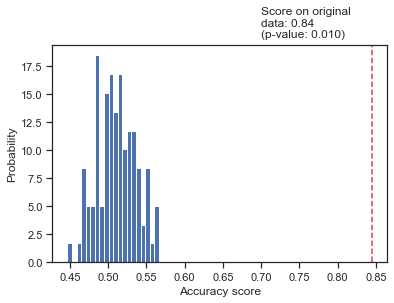

In [242]:
fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [ ]:
def draw_cv_roc_curve(classifier, cv, X, y, title='ROC Curve'):
    """
    Draw a Cross Validated ROC Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series
    Example largely taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    # Creating ROC Curve with Cross Validation
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    plt.figure(figsize=(20,10))
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    """
    Draw a Cross Validated PR Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series

    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    y_real = []
    y_proba = []
    plt.figure(figsize=(20,10))
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])

        # Plotting each individual PR Curve
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y.iloc[test], probas_[:, 1])))

        y_real.append(y.iloc[test])
        y_proba.append(probas_[:, 1])

        i += 1

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)

    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

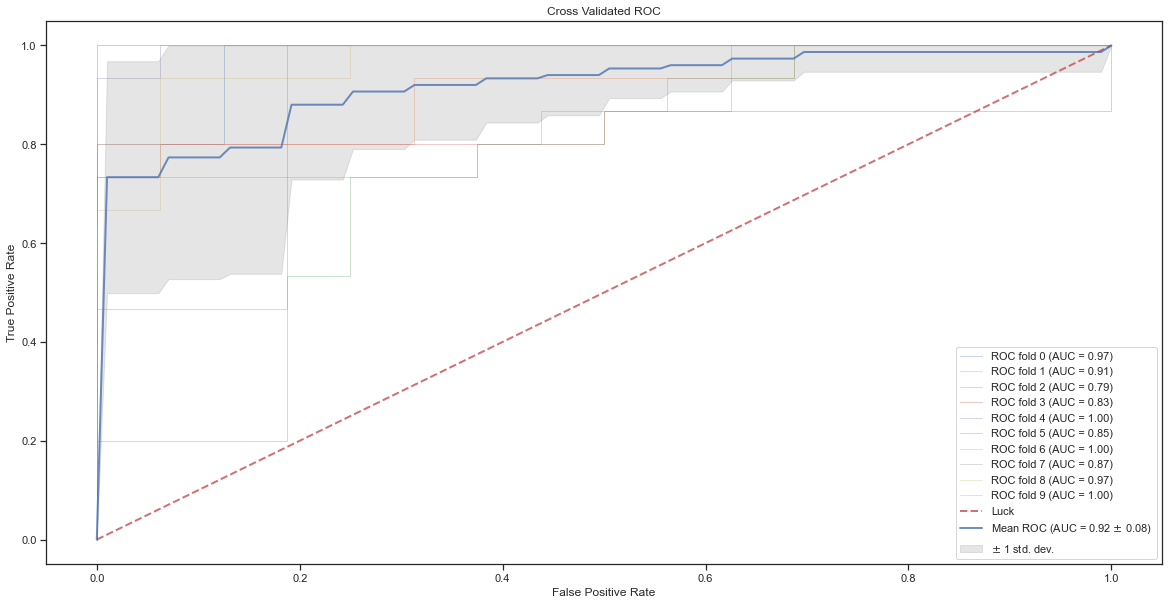

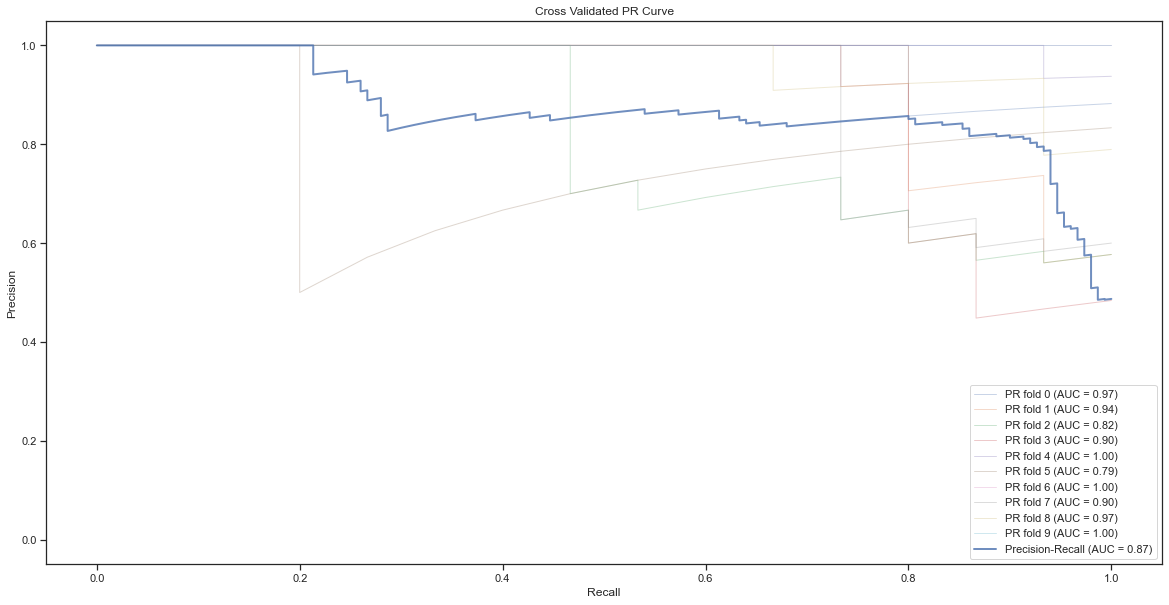

In [216]:
clf = LogisticRegression(C = 1.2, penalty= 'l2')
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

## B. K Nearest Neighbours

In [217]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

In [253]:
KNN_GridSearch = GridSearch(X_train_sc,y_train_sc,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPredict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_KNN).mean(),7))

Best: 0.957011 using {'n_neighbors': 3}
prediction on test set is: 0.9354839


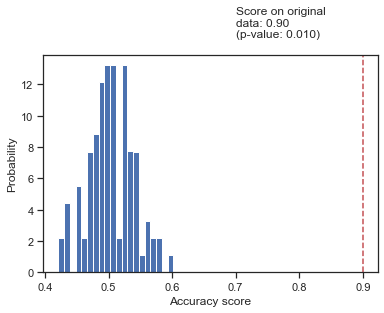

In [254]:
clf = KNeighborsClassifier(n_neighbors= 3)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 15, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [255]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = KNeighborsClassifier(n_neighbors= 3)
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

{'fit_time': array([0.01222301, 0.00990486, 0.01016402, 0.00955391, 0.00953698,
        0.00818706, 0.00784206, 0.00762796, 0.00737715, 0.00922799]),
 'score_time': array([0.03116107, 0.02889109, 0.02987003, 0.02947497, 0.02540016,
        0.02445698, 0.02433181, 0.02450109, 0.02429891, 0.02784586]),
 'test_accuracy': array([1.        , 0.80645161, 0.83870968, 0.83870968, 0.90322581,
        0.77419355, 0.87096774, 0.61290323, 0.80645161, 0.93333333]),
 'test_precision': array([1.        , 0.73684211, 0.77777778, 1.        , 1.        ,
        0.72222222, 0.82352941, 0.56      , 0.8       , 1.        ]),
 'test_recall': array([1.        , 0.93333333, 0.93333333, 0.66666667, 0.8       ,
        0.86666667, 0.93333333, 0.93333333, 0.8       , 0.86666667]),
 'test_f1': array([1.        , 0.82352941, 0.84848485, 0.8       , 0.88888889,
        0.78787879, 0.875     , 0.7       , 0.8       , 0.92857143]),
 'test_neg_brier_score': array([-0.00358423, -0.1218638 , -0.11469534, -0.09318996, -

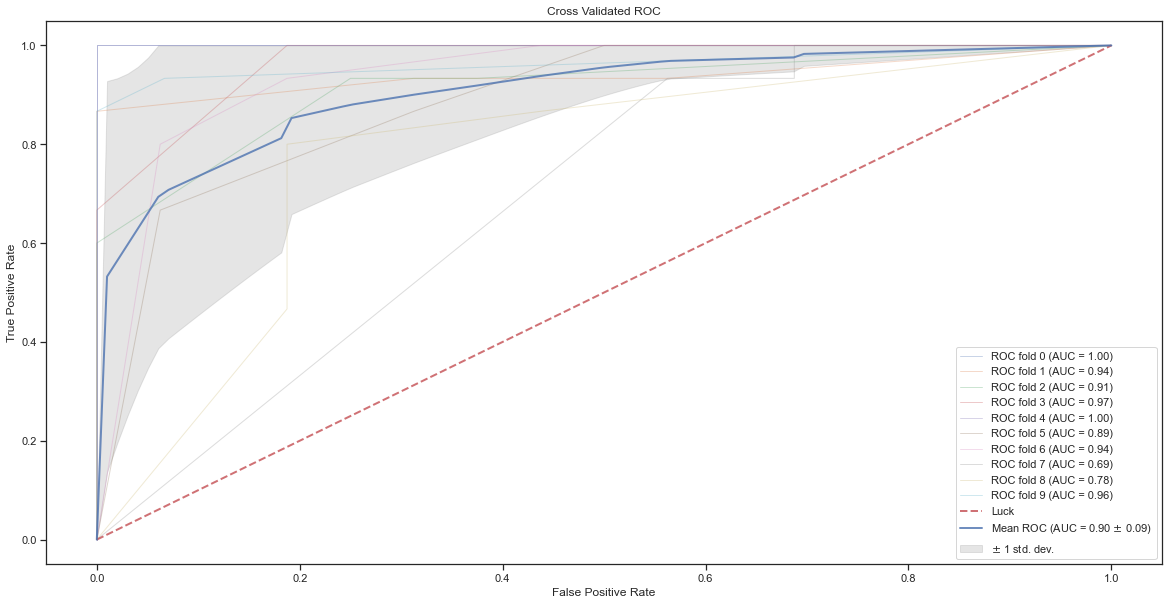

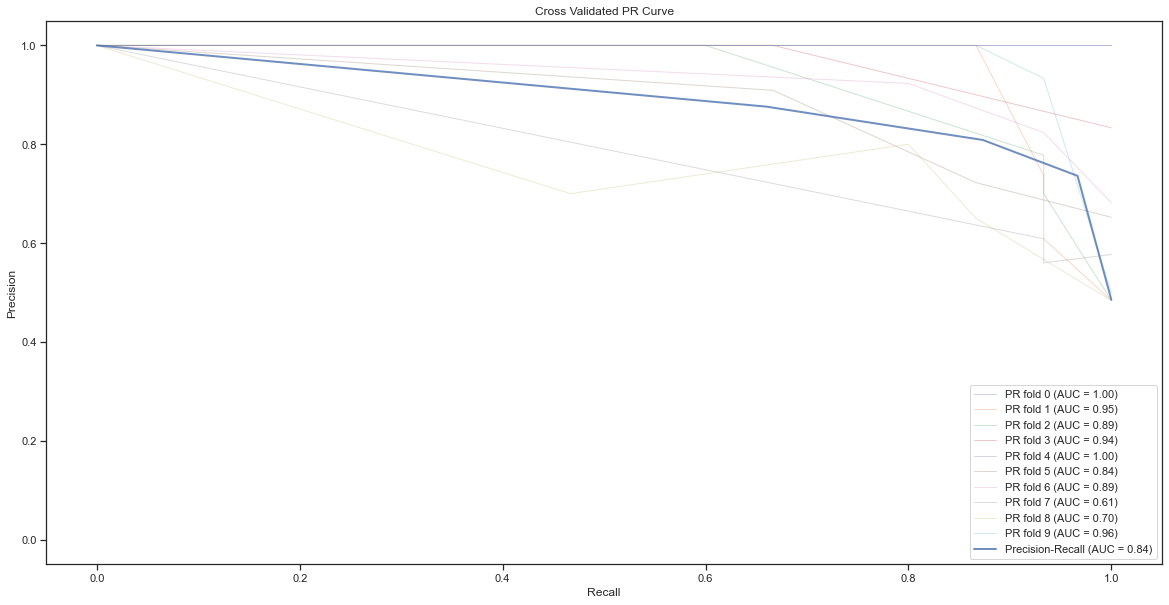

In [256]:
clf = KNeighborsClassifier(n_neighbors= 3)
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

## C. SVC

In [258]:
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]
param_grid = dict(C=c_values, kernel=kernel_values)
model_SVC = SVC()

In [259]:
SVC_GridSearch = GridSearch(X_train_sc,y_train_sc,model_SVC,param_grid)
Prediction_SVC = SVC_GridSearch.BestModelPredict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_SVC).mean(),7))

Best: 0.971296 using {'C': 0.1, 'kernel': 'poly'}
prediction on test set is: 1.0


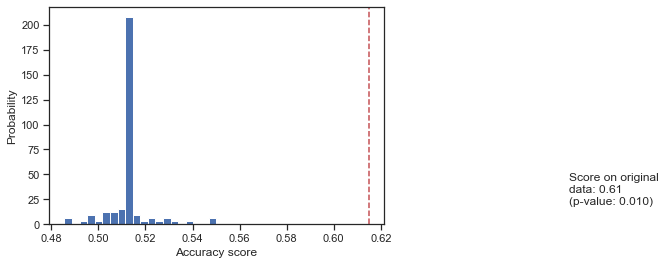

In [260]:
clf = SVC(C= 0.1, kernel= 'poly')

cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [263]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = SVC(C= 0.1, kernel= 'poly', probability=True)
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores


{'fit_time': array([0.36927509, 0.31472206, 0.34170079, 0.37368512, 0.33114314,
        0.34032011, 0.33423781, 0.31419301, 0.37436509, 0.39101219]),
 'score_time': array([0.03898787, 0.03994107, 0.03685904, 0.03859591, 0.03876877,
        0.03600407, 0.03779912, 0.0341599 , 0.0498929 , 0.04074693]),
 'test_accuracy': array([0.67741935, 0.48387097, 0.5483871 , 0.58064516, 0.5483871 ,
        0.5483871 , 0.67741935, 0.77419355, 0.80645161, 0.63333333]),
 'test_precision': array([1.        , 0.        , 1.        , 1.        , 1.        ,
        0.66666667, 1.        , 0.83333333, 1.        , 1.        ]),
 'test_recall': array([0.33333333, 0.        , 0.06666667, 0.13333333, 0.06666667,
        0.13333333, 0.33333333, 0.66666667, 0.6       , 0.26666667]),
 'test_f1': array([0.5       , 0.        , 0.125     , 0.23529412, 0.125     ,
        0.22222222, 0.5       , 0.74074074, 0.75      , 0.42105263]),
 'test_neg_brier_score': array([-0.1555912 , -0.22401912, -0.23074913, -0.23395339, -

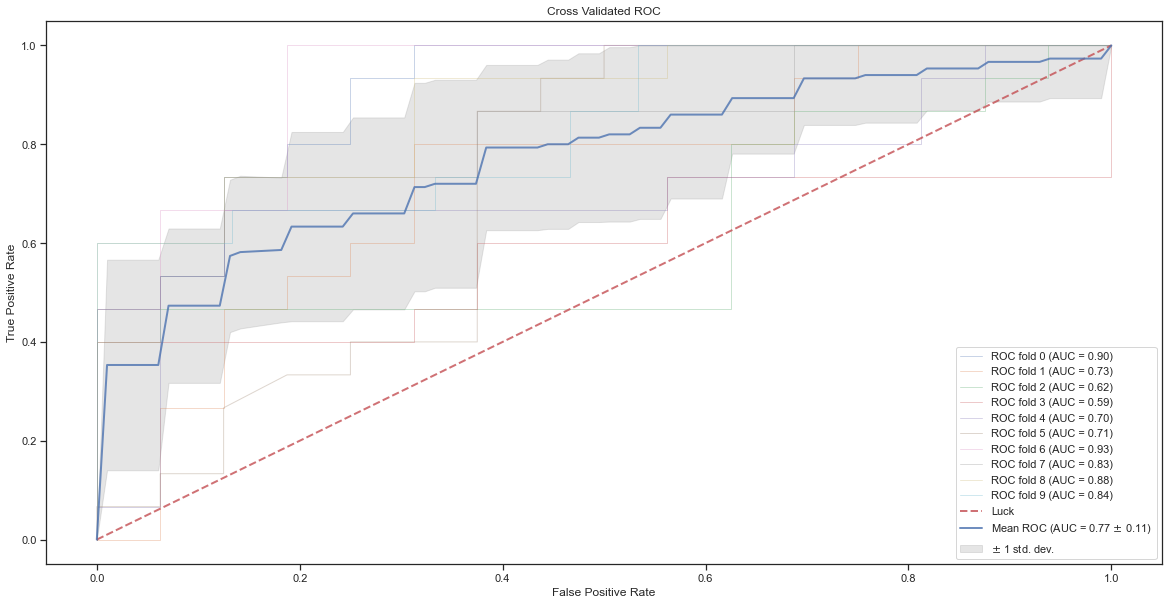

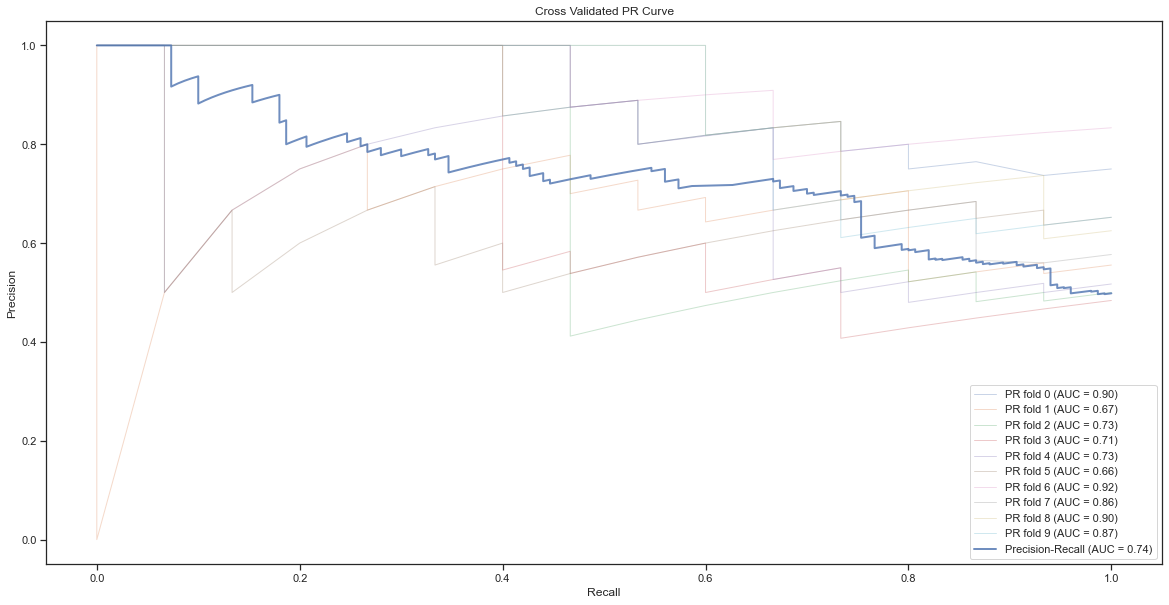

In [265]:
clf = SVC(C= 0.1, kernel= 'poly', probability=True)
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

## D. Decision Tree

In [133]:
from scipy.stats import randint
max_depth_value = [3, None]
max_features_value =  randint(1, 4)
min_samples_leaf_value = randint(1, 4)
criterion_value = ["gini", "entropy"]

In [134]:
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

In [135]:
model_CART = DecisionTreeClassifier()
CART_RandSearch = RandomSearch(X_train_sc,y_train_sc,model_CART,param_grid)
Prediction_CART = CART_RandSearch.BestModelPredict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_CART).mean(),7))

Best: 0.888360 using {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1}
prediction on test set is: 0.8709677


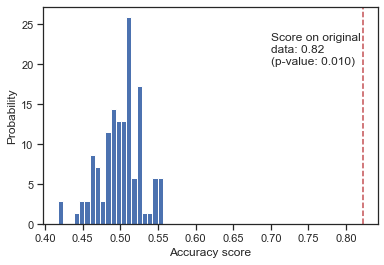

In [225]:
clf = DecisionTreeClassifier(criterion= 'gini', max_depth= None, max_features= 3, min_samples_leaf= 1)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [266]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = DecisionTreeClassifier(criterion= 'gini', max_depth= None, max_features= 3, min_samples_leaf= 1)
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

{'fit_time': array([0.00809503, 0.0076189 , 0.00800323, 0.00853395, 0.00731993,
        0.00816107, 0.00847483, 0.00748301, 0.00755024, 0.00988793]),
 'score_time': array([0.01537085, 0.01557398, 0.01644182, 0.01684308, 0.0159502 ,
        0.01722789, 0.01518321, 0.01419592, 0.01705074, 0.01714373]),
 'test_accuracy': array([0.80645161, 0.67741935, 1.        , 0.80645161, 0.70967742,
        0.80645161, 0.83870968, 0.41935484, 0.64516129, 0.7       ]),
 'test_precision': array([0.8       , 0.69230769, 1.        , 0.90909091, 0.71428571,
        0.76470588, 0.8125    , 0.42105263, 0.64285714, 0.6875    ]),
 'test_recall': array([0.8       , 0.6       , 1.        , 0.66666667, 0.66666667,
        0.86666667, 0.86666667, 0.53333333, 0.6       , 0.73333333]),
 'test_f1': array([0.8       , 0.64285714, 1.        , 0.76923077, 0.68965517,
        0.8125    , 0.83870968, 0.47058824, 0.62068966, 0.70967742]),
 'test_neg_brier_score': array([-0.19354839, -0.32258065, -0.        , -0.19354839, -

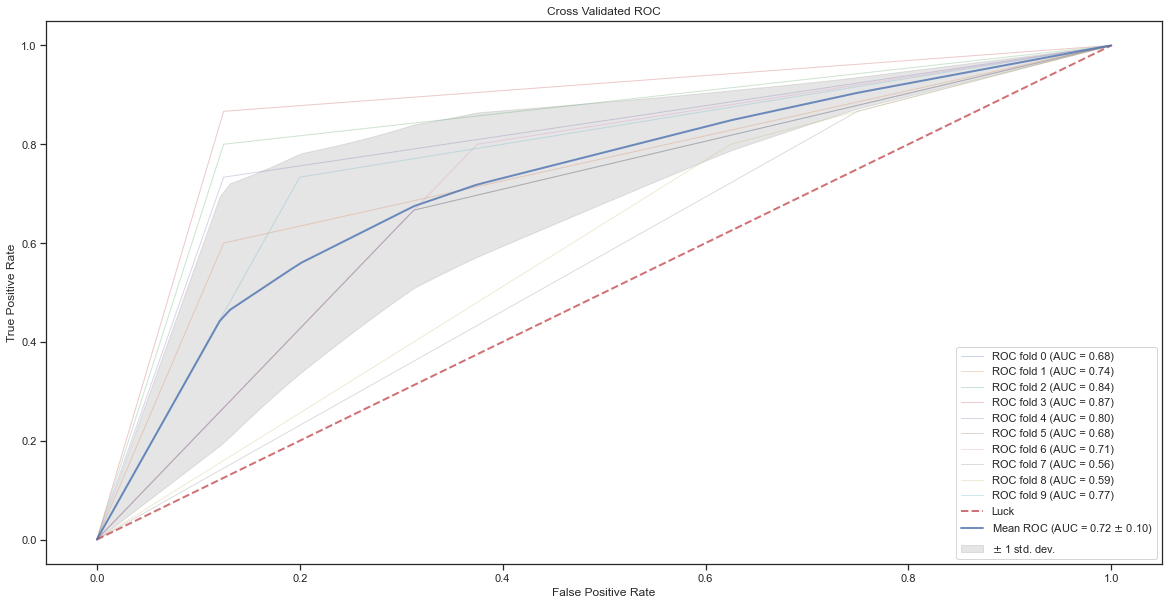

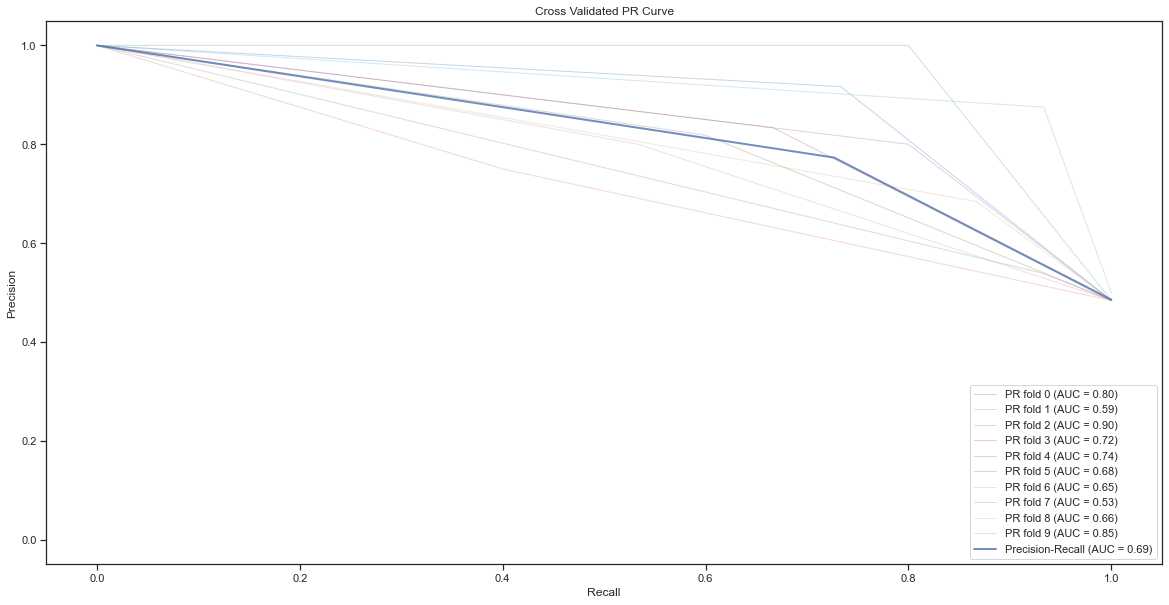

In [267]:
clf = DecisionTreeClassifier(criterion= 'gini', max_depth= None, max_features= 3, min_samples_leaf= 1)
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

## E. Adaboost Classifier

In [268]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [269]:
model_Ad = AdaBoostClassifier()
Ad_GridSearch = GridSearch(X_train_sc,y_train_sc,model_Ad,param_grid)
Prediction_Ad = Ad_GridSearch.BestModelPredict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_Ad).mean(),7))

Best: 0.939021 using {'learning_rate': 1, 'n_estimators': 100}
prediction on test set is: 1.0


In [270]:
clf = AdaBoostClassifier(learning_rate= 1, n_estimators= 100)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


KeyboardInterrupt: 

In [ ]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = AdaBoostClassifier(learning_rate= 1, n_estimators= 100)
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

In [ ]:
clf = AdaBoostClassifier(learning_rate= 1, n_estimators= 100)
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

## F. Gradient Boosting

In [138]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [139]:
model_GB = GradientBoostingClassifier()
GB_GridSearch = GridSearch(X_train_sc,y_train_sc,model_GB,param_grid)
Prediction_GB = GB_GridSearch.BestModelPredict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_GB).mean(),7))

Best: 0.942593 using {'learning_rate': 0.1, 'n_estimators': 250}
prediction on test set is: 0.9677419


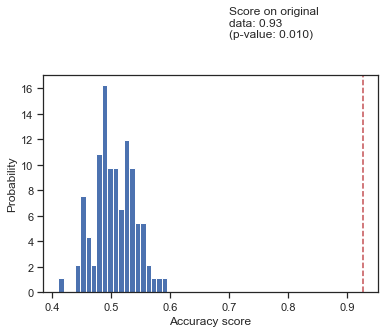

In [227]:
clf = GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 250)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [393]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 250)
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

{'fit_time': array([ 9.64274597,  9.77465391,  9.43343377,  9.84934807,  9.92949295,
        10.29897022,  9.485636  ,  9.58804917,  9.67449427,  9.92265821]),
 'score_time': array([0.01339197, 0.00394082, 0.00392509, 0.00522923, 0.00512195,
        0.00489283, 0.003932  , 0.00393677, 0.00544167, 0.00414896]),
 'test_accuracy': array([0.96774194, 0.90322581, 1.        , 0.96774194, 1.        ,
        0.96774194, 0.93548387, 0.64516129, 0.83870968, 0.96666667]),
 'test_precision': array([1.        , 0.92857143, 1.        , 1.        , 1.        ,
        0.9375    , 0.93333333, 0.57692308, 0.75      , 1.        ]),
 'test_recall': array([0.93333333, 0.86666667, 1.        , 0.93333333, 1.        ,
        1.        , 0.93333333, 1.        , 1.        , 0.93333333]),
 'test_f1': array([0.96551724, 0.89655172, 1.        , 0.96551724, 1.        ,
        0.96774194, 0.93333333, 0.73170732, 0.85714286, 0.96551724]),
 'test_neg_brier_score': array([-2.50350402e-02, -7.57466454e-02, -9.064402

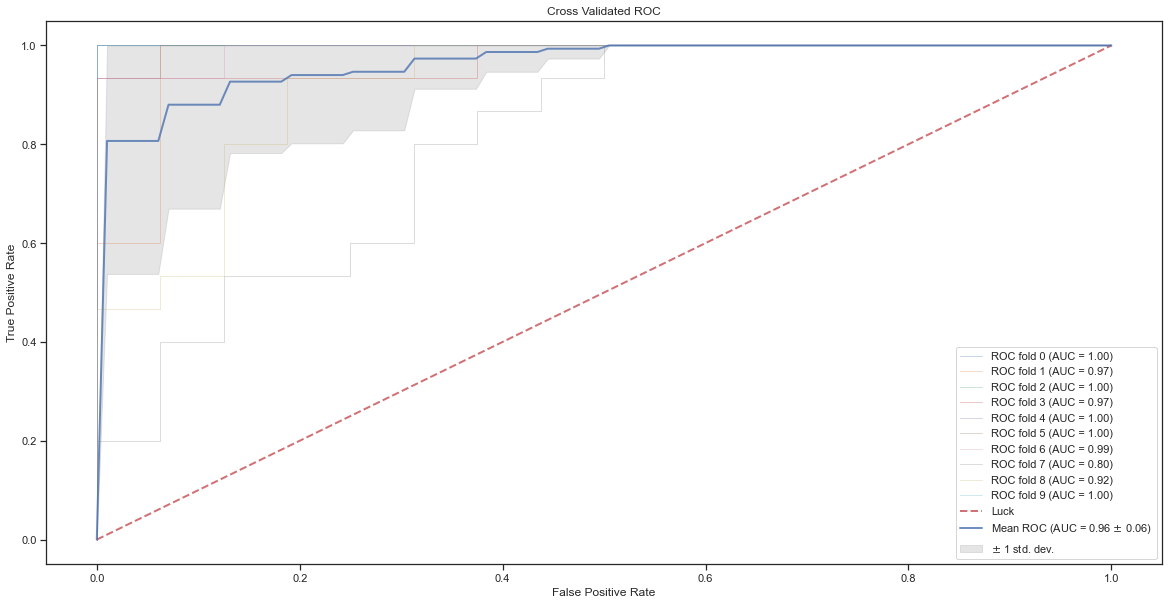

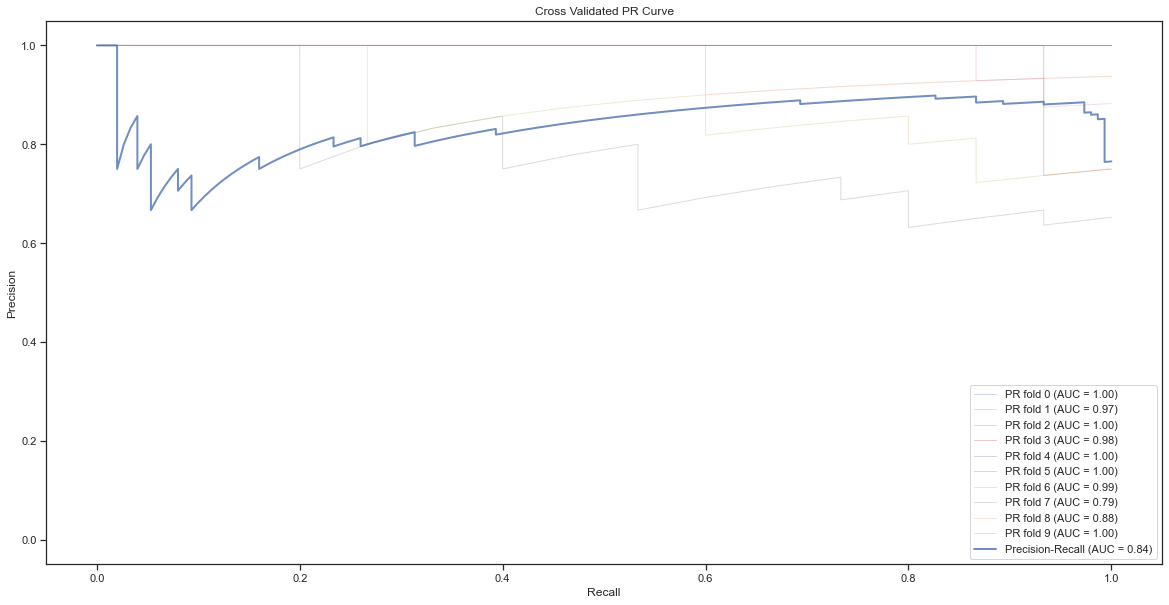

In [394]:
clf = GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 250)
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

## G. Random Forest

In [395]:
n_estimators = [100, 300, 500]
max_depth = [5, 10, 20]
min_samples_split = [10, 20, 50]
min_samples_leaf = [3, 5, 10] 

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

In [396]:
model_RF = RandomForestClassifier()
RF_GridSearch = GridSearch(X_train_sc,y_train_sc,model_RF,param_grid)
Prediction_RF = RF_GridSearch.BestModelPredict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_RF).mean(),7))

Best: 0.939021 using {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 500}
prediction on test set is: 0.9677419


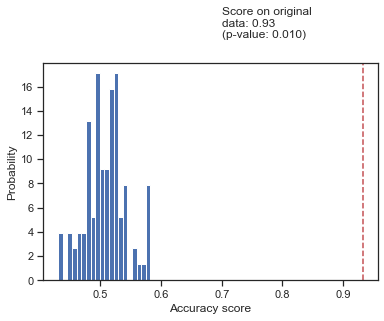

In [397]:
clf = RandomForestClassifier(max_depth= 5, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 500)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [398]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = RandomForestClassifier(max_depth= 5, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

{'fit_time': array([0.27388096, 0.20767117, 0.2041719 , 0.202528  , 0.20700693,
        0.20611   , 0.20679593, 0.20073175, 0.19795609, 0.20184684]),
 'score_time': array([0.01737404, 0.01518488, 0.01563978, 0.01644087, 0.01784611,
        0.01645803, 0.01648307, 0.01599526, 0.01686192, 0.01550889]),
 'test_accuracy': array([0.96774194, 0.93548387, 1.        , 0.93548387, 1.        ,
        0.96774194, 0.96774194, 0.64516129, 0.83870968, 1.        ]),
 'test_precision': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.57692308, 0.8125    , 1.        ]),
 'test_recall': array([0.93333333, 0.86666667, 1.        , 0.86666667, 1.        ,
        0.93333333, 0.93333333, 1.        , 0.86666667, 1.        ]),
 'test_f1': array([0.96551724, 0.92857143, 1.        , 0.92857143, 1.        ,
        0.96551724, 0.96551724, 0.73170732, 0.83870968, 1.        ]),
 'test_neg_brier_score': array([-0.0457813 , -0.04829027, -0.02958056, -0.05088128, -

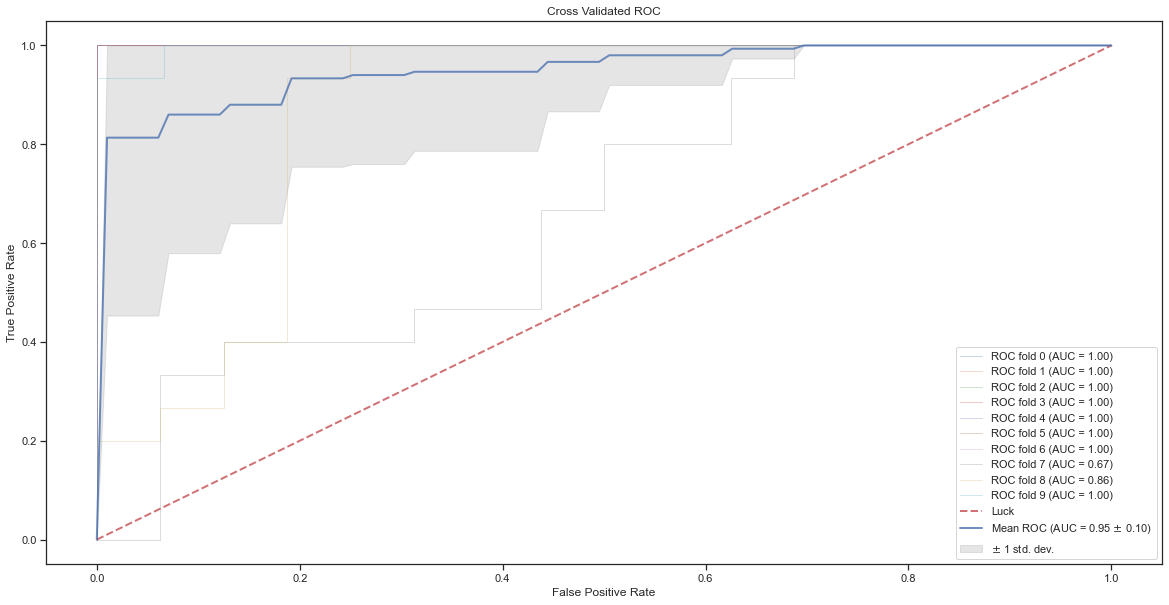

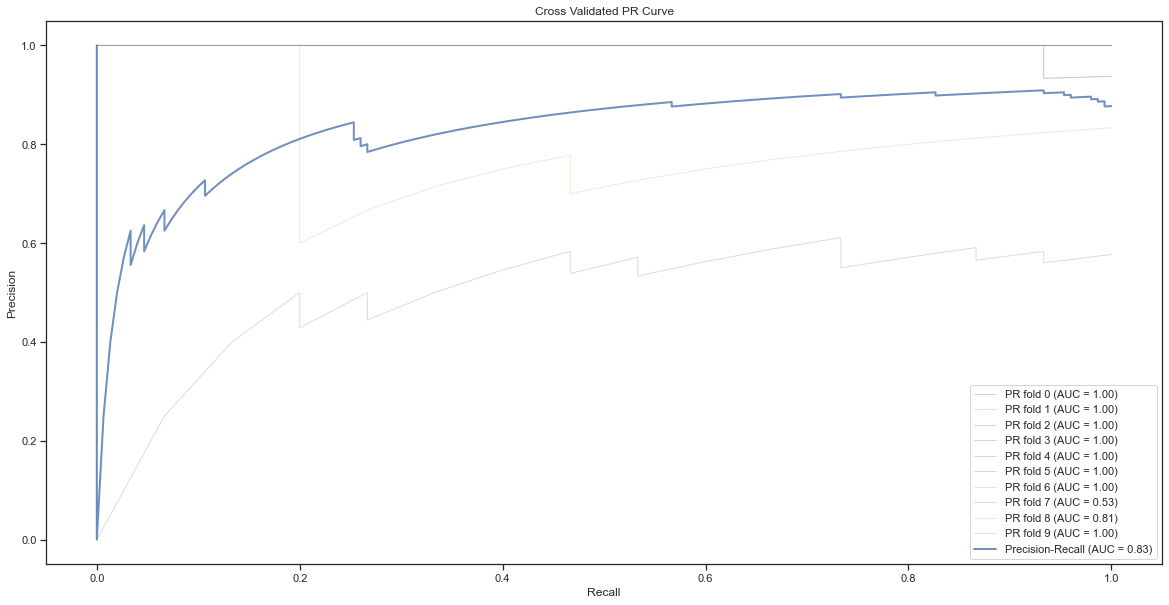

In [399]:
clf = RandomForestClassifier(max_depth= 5, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

## H. ExtraTrees

In [400]:
model_ET = ExtraTreesClassifier()
ET_GridSearch = GridSearch(X_train_sc,y_train_sc,model_ET,param_grid)
Prediction_ET = ET_GridSearch.BestModelPredict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_ET).mean(),7))

Best: 0.942593 using {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}
prediction on test set is: 0.9677419


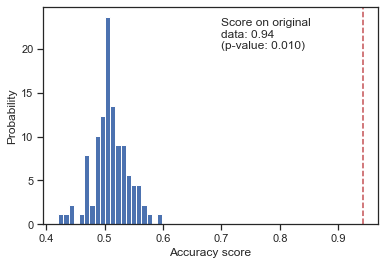

In [402]:
clf= ExtraTreesClassifier(max_depth= 5, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 300)
cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [403]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = ExtraTreesClassifier(max_depth= 20, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 100)
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

{'fit_time': array([0.10486293, 0.11282992, 0.09744787, 0.10332084, 0.11754799,
        0.13189006, 0.13227725, 0.12624598, 0.12835026, 0.13023496]),
 'score_time': array([0.01964188, 0.01584673, 0.01831198, 0.01850891, 0.02319813,
        0.02355385, 0.02359581, 0.02177882, 0.02346706, 0.02432299]),
 'test_accuracy': array([0.96774194, 0.93548387, 1.        , 0.96774194, 1.        ,
        1.        , 1.        , 0.64516129, 0.83870968, 0.93333333]),
 'test_precision': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.57692308, 0.77777778, 0.88235294]),
 'test_recall': array([0.93333333, 0.86666667, 1.        , 0.93333333, 1.        ,
        1.        , 1.        , 1.        , 0.93333333, 1.        ]),
 'test_f1': array([0.96551724, 0.92857143, 1.        , 0.96551724, 1.        ,
        1.        , 1.        , 0.73170732, 0.84848485, 0.9375    ]),
 'test_neg_brier_score': array([-0.06129475, -0.06939515, -0.04002331, -0.06469878, -

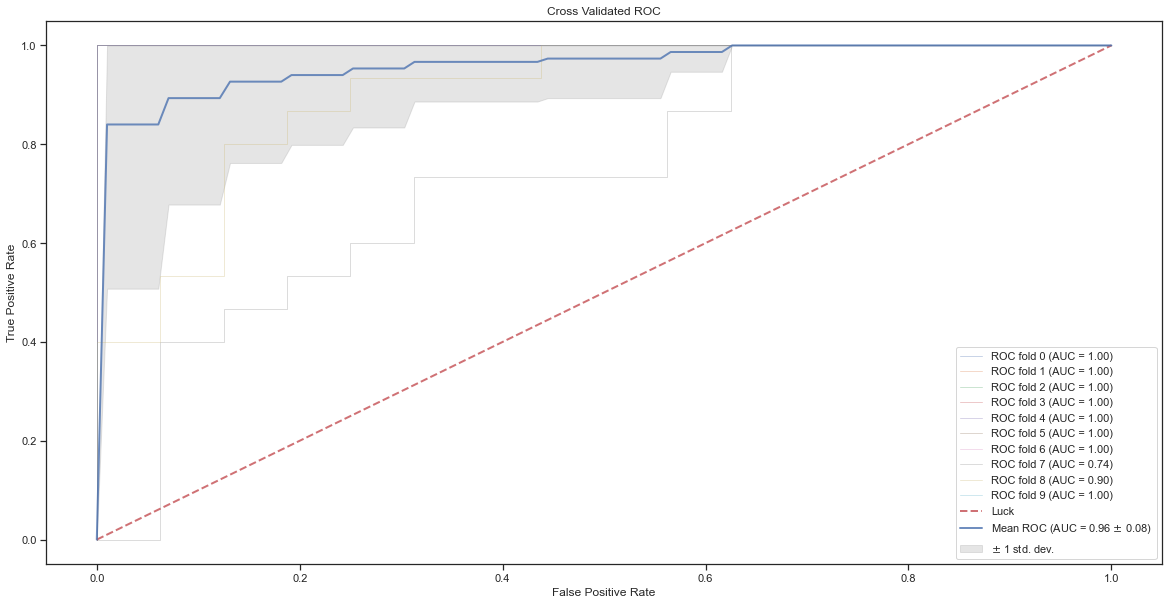

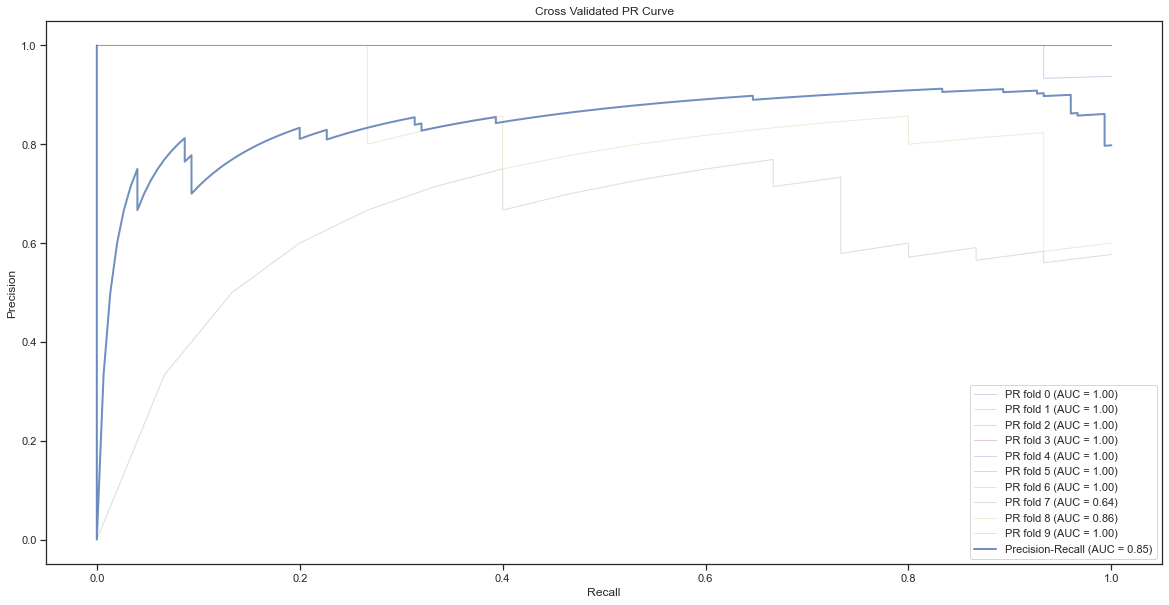

In [404]:
clf = ExtraTreesClassifier(max_depth= 20, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 100)
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

## I. Multi Layer Perceptron

In [278]:
from sklearn.neural_network import MLPClassifier

In [279]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [280]:
model_MLP = MLPClassifier()
MLP_GridSearch = GridSearch(X_train_sc,y_train_sc,model_MLP,param_grid)
Prediction_MLP = MLP_GridSearch.BestModelPredict(X_test_sc)
print('prediction on test set is:' ,floatingDecimals((y_test_sc == Prediction_MLP).mean(),7))

Best: 0.967725 using {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
prediction on test set is: 1.0


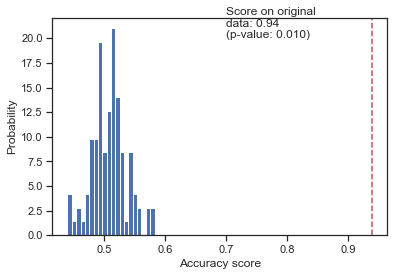

In [281]:
clf= MLPClassifier(activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (50, 50, 50), learning_rate= 'adaptive', solver= 'adam')
cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [282]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = MLPClassifier()
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

{'fit_time': array([0.65335703, 0.65808582, 0.66433096, 0.66692805, 0.66593623,
        0.65080905, 0.65402699, 0.663306  , 0.78464198, 0.78765798]),
 'score_time': array([0.01238608, 0.01349902, 0.01234484, 0.01245093, 0.01242876,
        0.01244903, 0.01260185, 0.01250505, 0.01445508, 0.01241589]),
 'test_accuracy': array([1.        , 1.        , 1.        , 0.96774194, 1.        ,
        0.90322581, 1.        , 0.64516129, 0.87096774, 1.        ]),
 'test_precision': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.83333333, 1.        , 0.57692308, 0.78947368, 1.        ]),
 'test_recall': array([1.        , 1.        , 1.        , 0.93333333, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]),
 'test_f1': array([1.        , 1.        , 1.        , 0.96551724, 1.        ,
        0.90909091, 1.        , 0.73170732, 0.88235294, 1.        ]),
 'test_neg_brier_score': array([-0.02474727, -0.01203912, -0.00624039, -0.04370377, -

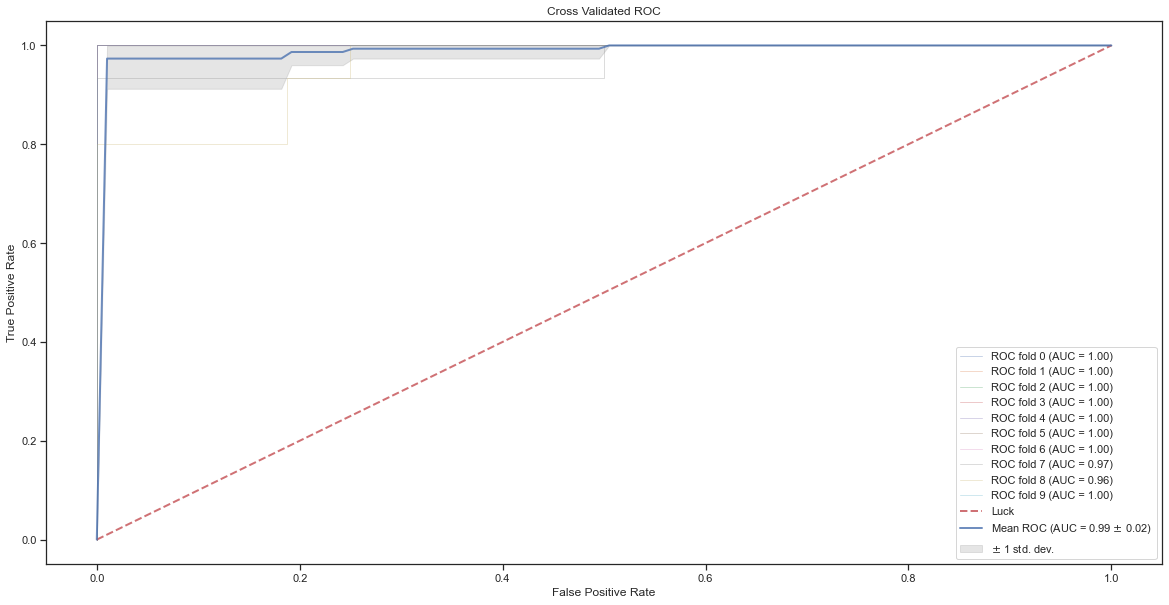

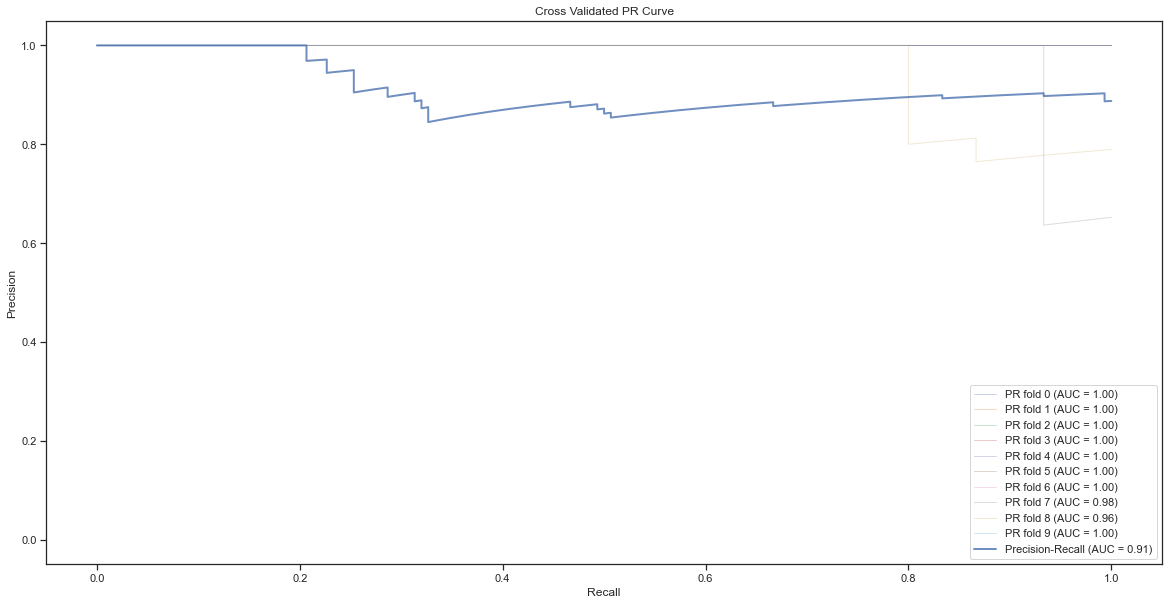

In [283]:
clf = MLPClassifier()
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

# Ensemble Classification Techniques

## A. Voting Ensemble

In [405]:
from sklearn.ensemble import VotingClassifier

In [406]:
param = {'C': 1.209330290527359, 'penalty': 'l2'}
model1 = LogisticRegression(**param)

param = {'n_neighbors': 3}
model2 = KNeighborsClassifier(**param)

param = {'C': 0.1, 'kernel': 'poly'}
model3 = SVC(**param)

param = {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1}
model4 = DecisionTreeClassifier(**param)

param = {'learning_rate': 1, 'n_estimators': 100}
model5 = AdaBoostClassifier(**param)

param = {'learning_rate': 0.1, 'n_estimators': 250}
model6 = GradientBoostingClassifier(**param)

param = {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 500}
model7 = RandomForestClassifier(**param)

param = {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}
model8 = ExtraTreesClassifier(**param)

param = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
model9 = MLPClassifier(**param)

In [407]:
estimators = [('LR',model1), ('KNN',model2), ('SVC',model3),
              ('DT',model4), ('ADA',model5), ('GB',model6),
              ('RF',model7), ('ET',model8),  ('MLP',model9)]

In [408]:
kfold = StratifiedKFold(n_splits=10, random_state=SEED)
ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X_train_sc,y_train_sc, cv=kfold)
print('Accuracy on train: ',results.mean())
ensemble_model = ensemble.fit(X_train_sc,y_train_sc)
pred = ensemble_model.predict(X_test_sc)
print('Accuracy on test:' , (y_test_sc == pred).mean())

Accuracy on train:  0.9604497354497354
Accuracy on test: 0.967741935483871


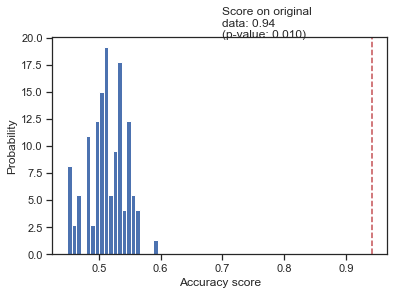

In [409]:
clf = VotingClassifier(estimators)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
n_uncorrelated_features = 900
X_rand = rng.normal(size=(spectra.iloc[:, :-1].shape[0], n_uncorrelated_features))

score, perm_scores, pvalue_score = permutation_test_score(
    clf, spectra.iloc[:, :-1], spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, spectra.iloc[:, -1], scoring="accuracy", cv=cv, n_permutations=100,n_jobs=4)

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls='--', color='r')
score_label = (f"Score on original\ndata: {score:.2f}\n"
               f"(p-value: {pvalue_score:.3f})")
ax.text(0.7, 20, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")


In [411]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'neg_brier_score', 'jaccard', 'roc_auc']
clf = VotingClassifier(estimators, voting="soft")
scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

AttributeError: predict_proba is not available when  probability=False

In [ ]:
clf = VotingClassifier(estimators, voting="soft")
cv = StratifiedKFold(n_splits=10)
draw_cv_roc_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated ROC')
draw_cv_pr_curve(clf, cv, X=spectra.iloc[:, :-1], y=pd.DataFrame([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), title='Cross Validated PR Curve')

In [412]:
def get_models():
    """Generate a library of base learners."""
    param = {'C': 1.209330290527359, 'penalty': 'l2'}
    model1 = LogisticRegression(**param)

    param = {'n_neighbors': 3}
    model2 = KNeighborsClassifier(**param)

    param = {'C': 0.1, 'kernel': 'poly'}
    model3 = SVC(**param)

    param = {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1}
    model4 = DecisionTreeClassifier(**param)

    param = {'learning_rate': 1, 'n_estimators': 100}
    model5 = AdaBoostClassifier(**param)

    param = {'learning_rate': 0.1, 'n_estimators': 250}
    model6 = GradientBoostingClassifier(**param)

    param = {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 500}
    model7 = RandomForestClassifier(**param)

    param = {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}
    model8 = ExtraTreesClassifier(**param)

    models = {'LR':model1, 'KNN':model2, 'SVC':model3,
              'DT':model4, 'ADA':model5, 'GB':model6,
              'RF':model7, 'ET':model8
              }

    return models

# Error Correlation

In [145]:
def train_predict(model_list,xtrain, xtest, ytrain, ytest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P

In [146]:
models = get_models()
P = train_predict(models,X_train_sc,X_test_sc,y_train_sc,y_test_sc)

Fitting models.
LR... done
KNN... done
SVC... done
DT... done
ADa... done
GB... done
NB... done
RF... done
ET... done
Done.



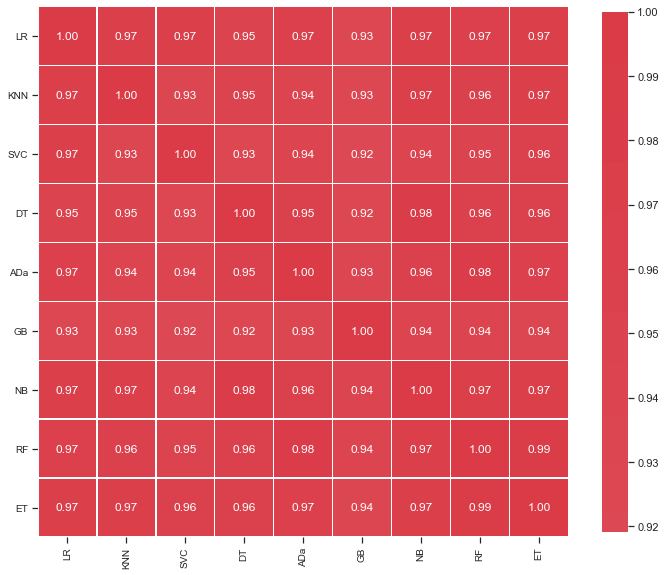

In [147]:
heatmap(P, method='pearson',annot=True)

In [148]:
P

LR       KNN       SVC        DT       ADa        GB             NB  \
0   0.982343  0.866667  1.000000  0.944444  0.596817  0.315954   1.000000e+00   
1   0.213780  0.133333  0.004432  0.000000  0.463405  0.193949   1.484012e-47   
2   0.063705  0.133333  0.011965  0.113636  0.335531  0.266529   1.448619e-82   
3   0.125458  0.200000  0.079072  0.113636  0.382282  0.249181   7.841471e-68   
4   0.201796  0.133333  0.348581  0.113636  0.426915  0.212753   6.724702e-10   
5   0.085307  0.133333  0.009261  0.113636  0.324421  0.212454   2.730768e-68   
6   0.132752  0.133333  0.071013  0.113636  0.357475  0.252225   4.146385e-32   
7   0.971218  1.000000  0.996358  0.888889  0.695018  0.821773   1.000000e+00   
8   0.965055  1.000000  0.999997  0.944444  0.667369  0.821773   1.000000e+00   
9   0.048287  0.133333  0.003814  0.113636  0.392872  0.232317   2.642876e-65   
10  0.271244  0.066667  0.275149  0.113636  0.427492  0.369751   5.563849e-24   
11  0.975224  0.866667  1.000000  0.989583  0.682941  0.821773   1.000000e+00   
12  0.495081  0.266667  0.864997  0.113636  0.449268  0.395632   2.394602e-36   
13  0.979399  1.000000  0.999988  0.888889  0.655593  0.821773   1.000000e+00   
14  0.961713  1.000000  0.997117  0.666667  0.621751  0.821773   1.000000e+00   
15  0.312227  0.333333  0.115105  0.113636  0.407230  0.242558   2.561021e-52   
16  0.347480  0.200000  0.013339  0.113636  0.419956  0.244038   2.026589e-11   
17  0.025796  0.000000  0.000282  0.113636  0.323672  0.252659  1.459266e-119   
18  0.983553  1.000000  1.000000  0.989583  0.698658  0.821773   1.000000e+00   
19  0.948565  1.000000  0.991754  0.989583  0.700088  0.821773   1.000000e+00   
20  0.934638  1.000000  0.999987  0.989583  0.672821  0.821773   1.000000e+00   
21  0.163872  0.066667  0.016275  0.113636  0.407087  0.249181   1.227388e-52   
22  0.955713  1.000000  1.000000  0.666667  0.584300  0.821773   1.000000e+00   
23  0.911931  1.000000  0.979295  0.989583  0.671443  0.821773   1.000000e+00   
24  0.781964  0.600000  0.954414  0.989583  0.624691  0.821773   9.999967e-01   
25  0.979878  1.000000  0.999999  0.989583  0.647899  0.821773   1.000000e+00   
26  0.081479  0.266667  0.021741  0.113636  0.327036  0.259793   1.681845e-73   
27  0.941947  1.000000  0.994784  0.989583  0.659295  0.821773   1.000000e+00   
28  0.979341  1.000000  1.000000  0.989583  0.724640  0.821773   1.000000e+00   
29  0.029092  0.000000  0.000348  0.113636  0.392724  0.233039   5.240676e-33   
30  0.093239  0.200000  0.003755  0.113636  0.337797  0.212454   6.592271e-77   

      RF    ET  
0   0.76  0.82  
1   0.29  0.10  
2   0.10  0.12  
3   0.12  0.14  
4   0.42  0.47  
5   0.02  0.04  
6   0.12  0.06  
7   0.98  0.99  
8   0.95  0.93  
9   0.19  0.10  
10  0.26  0.14  
11  0.92  0.82  
12  0.22  0.25  
13  0.94  0.94  
14  0.79  0.89  
15  0.10  0.10  
16  0.19  0.21  
17  0.06  0.04  
18  1.00  1.00  
19  1.00  0.98  
20  0.95  0.97  
21  0.11  0.06  
22  0.92  0.93  
23  0.98  0.98  
24  0.76  0.71  
25  0.95  0.96  
26  0.03  0.07  
27  0.98  0.95  
28  1.00  0.99  
29  0.10  0.07  
30  0.05  0.05

# Stacking

In [413]:
from mlens.ensemble import SuperLearner

[MLENS] backend: threading


In [423]:
base_learners = get_models()
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=6,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.001, 
    random_state=SEED
)

In [415]:
base_learners = get_models()
meta_learner = MLPClassifier(activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (50, 50, 50), learning_rate= 'adaptive', solver= 'adam')


In [425]:
# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=2,
    random_state=SEED,
    verbose=4,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train_sc, y_train_sc)

# Predict the test set
p_sl = sl.predict_proba(X_test_sc)


Fitting 2 layers
Processing layer-1            
Learners ...                  


KeyboardInterrupt: 

In [ ]:
pp = []
for p in p_sl[:, 1]:
    if p>0.5:
        pp.append(1.)
    else:
        pp.append(0.)

In [ ]:
print("\nSuper Learner Accuracy score: %.8f" % (y_test_sc== pp).mean())

# Decision Border Graphs

In [285]:
from mlxtend.plotting import plot_decision_regions

In [300]:
def decision_border(X, y, classifier, title):
     
    scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled)

    classifier.fit(components, y)

    # Plotting decision regions
    ax = plot_decision_regions(components, y, clf=classifier, legend=0)

    # Adding axes annotations
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, 
              ['Healthy', "SARS-CoV-2"], 
               framealpha=0.3, scatterpoints=1)

    plt.show()

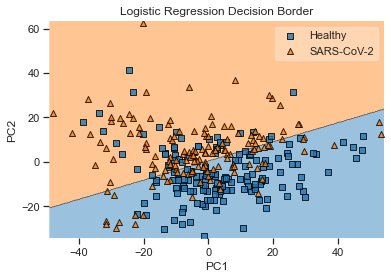

In [303]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier=LogisticRegression(C = 1.2, penalty= 'l2'), 
                title='Logistic Regression Decision Border')

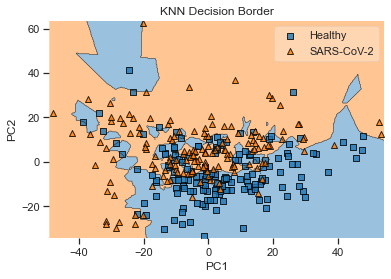

In [304]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier=KNeighborsClassifier(n_neighbors= 3), 
                title='KNN Decision Border')

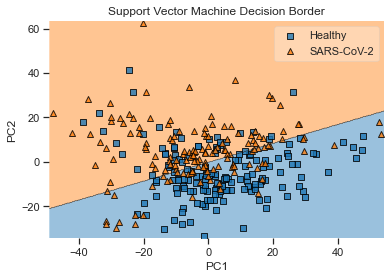

In [307]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier=SVC(C=0.5, kernel='linear'), 
                title='Support Vector Machine Decision Border')

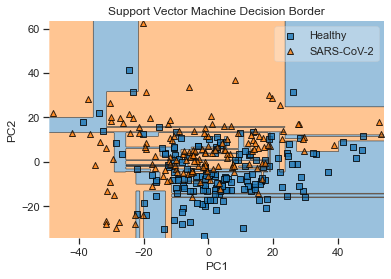

In [315]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier=DecisionTreeClassifier(criterion= 'gini', max_depth= None, max_features= 2, min_samples_leaf= 1), 
                title='Support Vector Machine Decision Border')

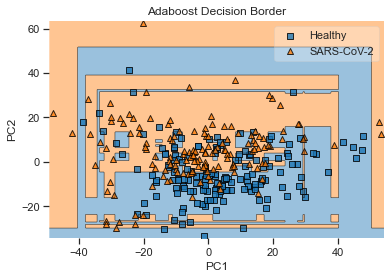

In [309]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier=AdaBoostClassifier(learning_rate= 1, n_estimators= 100), 
                title='Adaboost Decision Border')

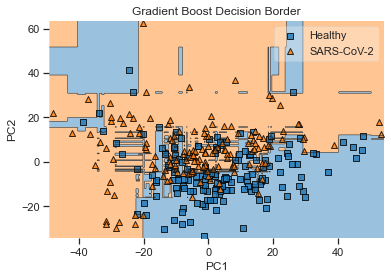

In [310]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier=GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 250), 
                title='Gradient Boost Decision Border')

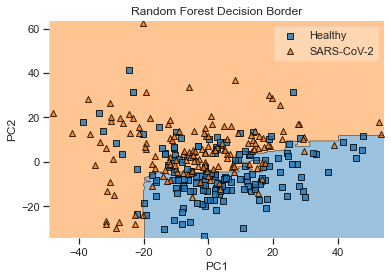

In [311]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier=RandomForestClassifier(max_depth= 5, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100), 
                title='Random Forest Decision Border')

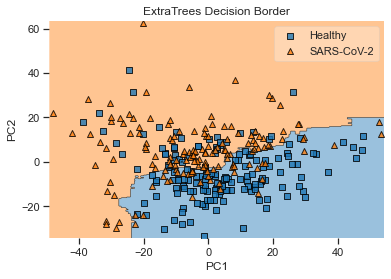

In [312]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier=ExtraTreesClassifier(max_depth= 20, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 100), 
                title='ExtraTrees Decision Border')

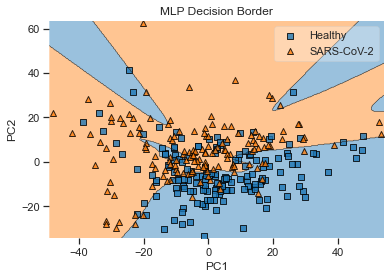

In [314]:
decision_border(X=np.array(spectra.iloc[:, :-1]), 
                y=np.array([1 if x == "Healthy" else 0 for x in spectra.iloc[:, -1]]), 
                classifier= MLPClassifier(activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (50, 50, 50), learning_rate= 'adaptive', solver= 'adam'), 
                title='MLP Decision Border')

In [ ]:
def plot_something(data, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Do some cool data transformations...
    return ax.boxplot(data, **kwargs)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
plot_something(data1, ax1, color='blue')
plot_something(data2, ax2, color='red')

# Final Model Pipeline

In [368]:
from scipy.signal.signaltools import wiener

#normalization to baseline
#feature selection 
#outlier exclusion/filtering training set
#weiner filter/Savitzky-Golay (SG) algorithm (https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-1-200&id=423997)
#Standard Normal Variate (SNV) Normalization
#pca
#train model
#test and validate model 
#cross validation metrics, roc, auc 

In [324]:
def baseline(spectra):
    return spectra.iloc[:, :-1] - tube.mean(axis=0)

In [325]:
normalized_spectra = baseline(spectra)

In [347]:
def feature_select(normalized_spectra, n_features):
    forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=rng)

    forest.fit(normalized_spectra, spectra.iloc[:, -1])
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    return normalized_spectra.iloc[:, indices[:n_features]]

In [349]:
select_spectra = feature_select(normalized_spectra, n_features=100)

In [354]:
def outlier_drop(select_spectra):

    Q1 = select_spectra.quantile(0.25)
    Q3 = select_spectra.quantile(0.75)
    IQR = Q3 - Q1
    idx = ~((select_spectra < (Q1 - 3 * IQR)) | (select_spectra > (Q3 + 3 * IQR))).any(axis=1)
    
    return select_spectra.loc[idx]


In [355]:
clean_spectra = outlier_drop(select_spectra)

In [384]:
clean_spectra_index = clean_spectra.index

In [377]:
def weiner_filter(clean_spectra):
    return scipy.signal.wiener(clean_spectra)

In [378]:
filter_spectra = weiner_filter(clean_spectra)

In [379]:
def standard_scaling(filter_spectra):
    scaler = StandardScaler()
    return scaler.fit_transform(filter_spectra)

In [380]:
scaled_spectra = standard_scaling(filter_spectra)

In [390]:
def pca_reduce(scaled_spectra, explained_variance):

    for n in range(1, min(scaled_spectra.shape), 1):
        pca_components = PCA(n_components=n)
        pca_transform = pca_components.fit_transform(scaled_spectra)
        if sum(pca_components.explained_variance_ratio_) < explained_variance:
            pass
        else:
            pca_components_final = PCA(n_components=n)
            pca_transform = pca_components_final.fit_transform(scaled_spectra)
            pca_df = pd.DataFrame(data = pca_transform, index = clean_spectra_index, columns = ["pc_" + str(x) for x in range(1, n+1)])
            break
    return pca_df  

In [392]:
processed_spectra = pca_reduce(scaled_spectra, 0.99)

In [417]:
base_learners = get_models()
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=6,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.001, 
    random_state=SEED)

base_learners = get_models()
meta_learner = MLPClassifier(activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (50, 50, 50), learning_rate= 'adaptive', solver= 'adam')


In [539]:
list(base_learners.values())

[LogisticRegression(C=1.209330290527359),
 KNeighborsClassifier(n_neighbors=3),
 SVC(C=0.1, kernel='poly'),
 DecisionTreeClassifier(max_features=3),
 AdaBoostClassifier(learning_rate=1, n_estimators=100),
 GradientBoostingClassifier(n_estimators=250),
 RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=10,
                        n_estimators=500),
 ExtraTreesClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=10,
                      n_estimators=300)]

In [564]:
processed_spectra = processed_spectra.sample(frac=1)

In [588]:
x=np.array(processed_spectra)
y=np.array([0 if spectra.loc[x, "diagnostic"] == "Healthy" else 1 for x in processed_spectra.index])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

In [594]:
from xgboost import XGBClassifier

In [610]:
from sklearn.metrics import accuracy_score

seed = 2017
np.random.seed(seed)

def accuracy(y, p): return accuracy_score(y, p)


# --- Build ---

# Passing a scoring function will create cv scores during fitting
# the scorer should be a simple function accepting to vectors and returning a scalar
ensemble = SuperLearner(scorer=accuracy, random_state=seed)

# Build the first layer
ensemble.add(list(base_learners.values()))

# Attach the final meta estimator
#ensemble.add_meta(MLPClassifier(activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (50, 50, 50), learning_rate= 'adaptive', solver= 'adam', early_stopping=True))
ensemble.add_meta(SVC())
# --- Use ---

# Fit ensemble
ensemble.fit(X_train, y_train)

# Predict
preds = ensemble.predict(X_test)

In [611]:
accuracy(preds, y_test)

0.9708333333333333

In [557]:
ensemble.data

                                       score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier               0.95     0.01  1.59  0.00  0.09  0.01
layer-1  decisiontreeclassifier           0.63     0.04  0.30  0.11  0.00  0.00
layer-1  extratreesclassifier             0.95     0.02  2.82  0.03  0.09  0.01
layer-1  gradientboostingclassifier       0.91     0.02  2.62  0.00  0.00  0.00
layer-1  kneighborsclassifier             0.95     0.01  0.05  0.05  0.70  0.04
layer-1  logisticregression               0.97     0.00  0.01  0.00  0.04  0.04
layer-1  randomforestclassifier           0.95     0.02  3.15  0.01  0.11  0.00
layer-1  svc                              0.91     0.02  0.06  0.03  0.02  0.00

In [552]:
from mlens.preprocessing import Subset
from sklearn.preprocessing import StandardScaler
from mlens.model_selection import Evaluator

# Map preprocessing cases through a dictionary
preprocess_cases = {'none': [],
                    'sc': [StandardScaler()],
                    'sub': [Subset([0, 1])]
                    }

In [554]:
evaluator = Evaluator(accuracy_score, cv=10, random_state=seed, verbose=1)
evaluator.preprocess(np.array(processed_spectra), np.array([0 if spectra.loc[x, "diagnostic"] == "Healthy" else 1 for x in processed_spectra.index]), preprocess_cases)

ValueError: The passes scorer does not seem to be a valid scorer. Expected type '_PredictScorer', got 'function'. Use the mlens.metrics.make_scorer function to construct a valid scorer.